In [1]:
%matplotlib inline
from Mumulader.simulations_feature_selection import generate_dataset
from Mumulader.lasso_wrappers import LASSO, LASSOSPAMS
from sklearn.cross_validation import KFold
import numpy as np 
import matplotlib.pylab as plt
import seaborn as sns
import psutil
import mkl
mkl.set_num_threads(1)
import copy
from Mumulader.mumulader import MuMuLaDer
from Mumulader.mumulas import MuMuLas
from Mumulader.mulas import MuLas
from Mumulader.sparse_mulas import SparseMuLas
import sys

import shelve
cmap = sns.light_palette(sns.xkcd_rgb["orange"], as_cmap=True)

/home/victor/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/victor/anaconda2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
shelf = shelve.open("../Stability_selection_2_thetas.shelve")

In [4]:
#shelf.sync()
shelf.close()

In [3]:
#normal_data_list = shelf['normal_data_list']
#normal_beta_list = shelf['normal_beta_list']
#normal_noisy_descriptors = shelf['normal_noisy_descriptors']
#normal_random_descriptors = shelf['normal_random_descriptors']

#normal_betas_bellon = shelf['normal_betas_bellon']
#normal_betas_bellon_noise = shelf['normal_betas_bellon_noise']
#normal_betas_bellon_random = shelf['normal_betas_bellon_random']
#normal_betas_obozinski = shelf['normal_betas_obozinski']
#normal_betas_lozano = shelf['normal_betas_lozano']
#normal_betas_sparse = shelf['normal_betas_sparse']
#normal_betas_random = shelf['normal_betas_random']

#normal_pred_bellon = shelf['normal_pred_bellon']
#normal_pred_bellon_noise = shelf['normal_pred_bellon_noise']
#normal_pred_bellon_random = shelf['normal_pred_bellon_random']
#normal_pred_obozinski = shelf['normal_pred_obozinski']
#normal_pred_lozano = shelf['normal_pred_lozano']
#normal_pred_sparse = shelf['normal_pred_sparse']
#normal_pred_random = shelf['normal_pred_random']

#normal_path_bellon = shelf['normal_path_bellon']
#normal_path_bellon_noise = shelf['normal_path_bellon_noise']
#normal_path_bellon_random = shelf['normal_path_bellon_random']
#normal_path_obozinski = shelf['normal_path_obozinski']
#normal_path_lozano = shelf['normal_path_lozano']
#normal_path_sparse = shelf['normal_path_sparse']
#normal_path_random = shelf['normal_path_random']

#normal_y_test = shelf['normal_y_test']

#normal_folds_list = shelf['normal_folds_list']

scarce_data_list = shelf['scarce_data_list']
scarce_beta_list = shelf['scarce_beta_list']
scarce_noisy_descriptors = shelf['scarce_noisy_descriptors']
scarce_random_descriptors = shelf['scarce_random_descriptors']

scarce_betas_bellon = shelf['scarce_betas_bellon']
#scarce_betas_bellon_noise = shelf['scarce_betas_bellon_noise']
#scarce_betas_bellon_random = shelf['scarce_betas_bellon_random']
#scarce_betas_obozinski = shelf['scarce_betas_obozinski']
#scarce_betas_lozano = shelf['scarce_betas_lozano']
#scarce_betas_sparse = shelf['scarce_betas_sparse']
scarce_betas_random = shelf['scarce_betas_random']

scarce_pred_bellon = shelf['scarce_pred_bellon']
#scarce_pred_bellon_noise = shelf['scarce_pred_bellon_noise']
#scarce_pred_bellon_random = shelf['scarce_pred_bellon_random']
#scarce_pred_obozinski = shelf['scarce_pred_obozinski']
#scarce_pred_lozano = shelf['scarce_pred_lozano']
#scarce_pred_sparse = shelf['scarce_pred_sparse']
scarce_pred_random = shelf['scarce_pred_random']

scarce_path_bellon = shelf['scarce_path_bellon']
#scarce_path_bellon_noise = shelf['scarce_path_bellon_noise']
#scarce_path_bellon_random = shelf['scarce_path_bellon_random']
#scarce_path_obozinski = shelf['scarce_path_obozinski']
#scarce_path_lozano = shelf['scarce_path_lozano']
#scarce_path_sparse = shelf['scarce_path_sparse']
scarce_path_random = shelf['scarce_path_random']

scarce_y_test = shelf['scarce_y_test']

scarce_folds_list = shelf['scarce_folds_list']

reps=5


# Data correlation

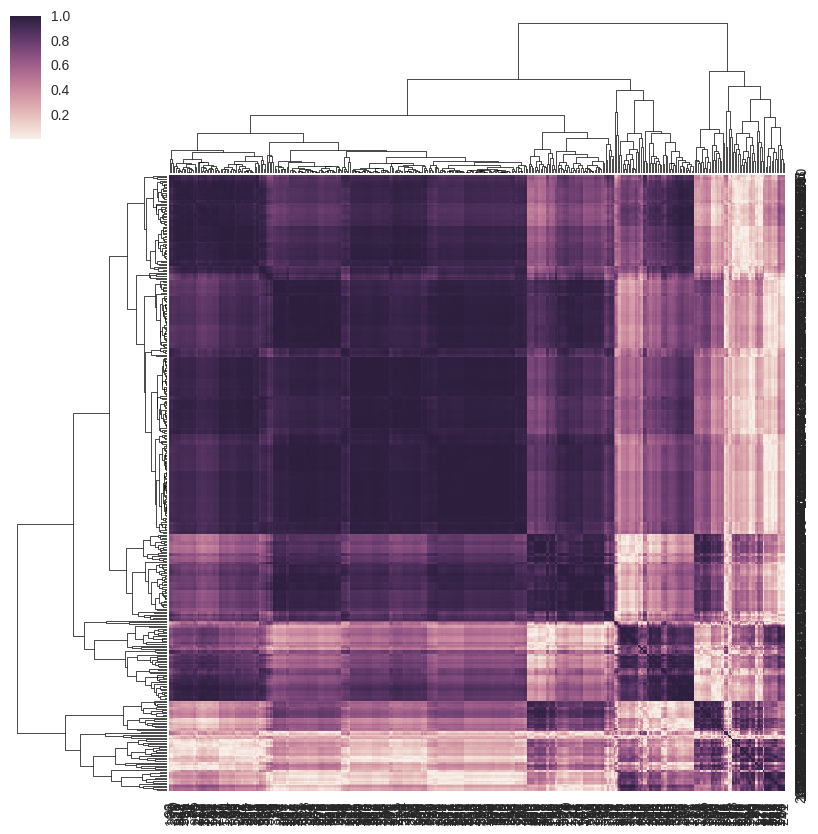

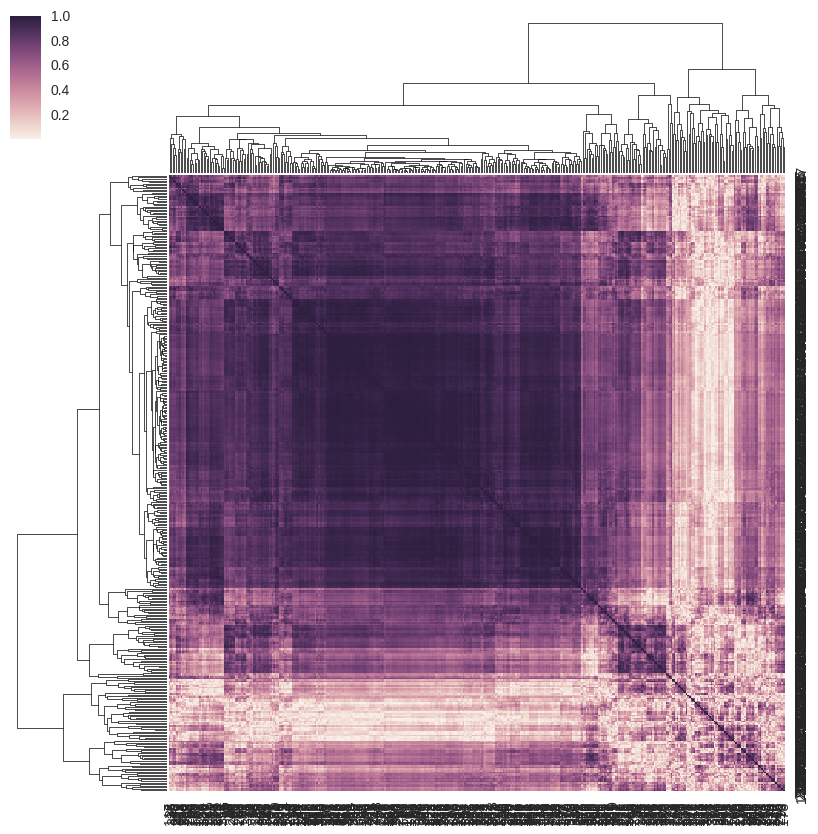

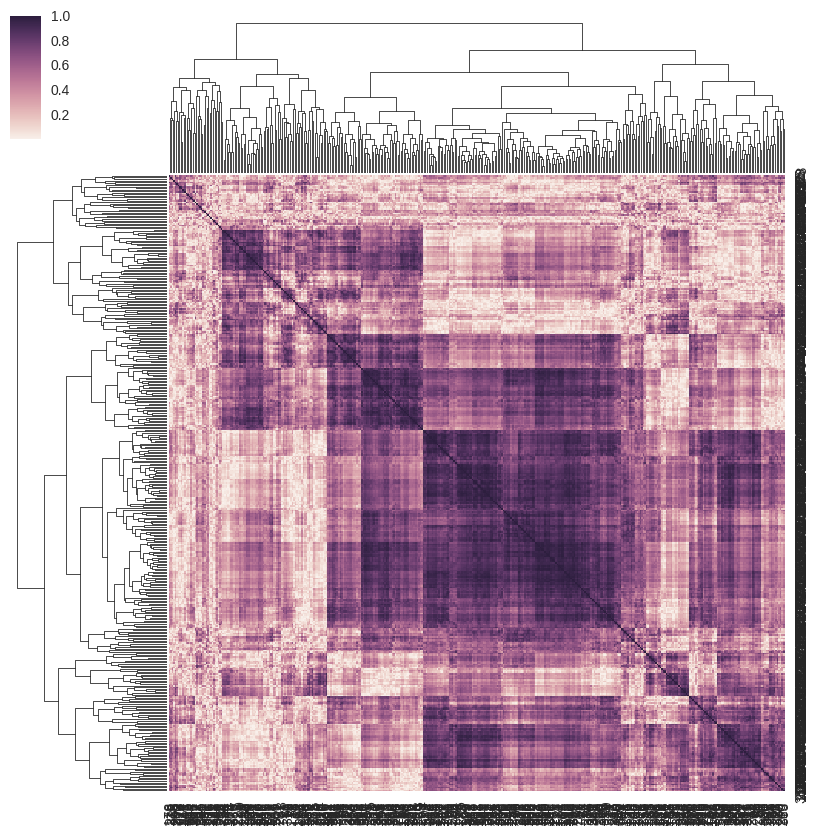

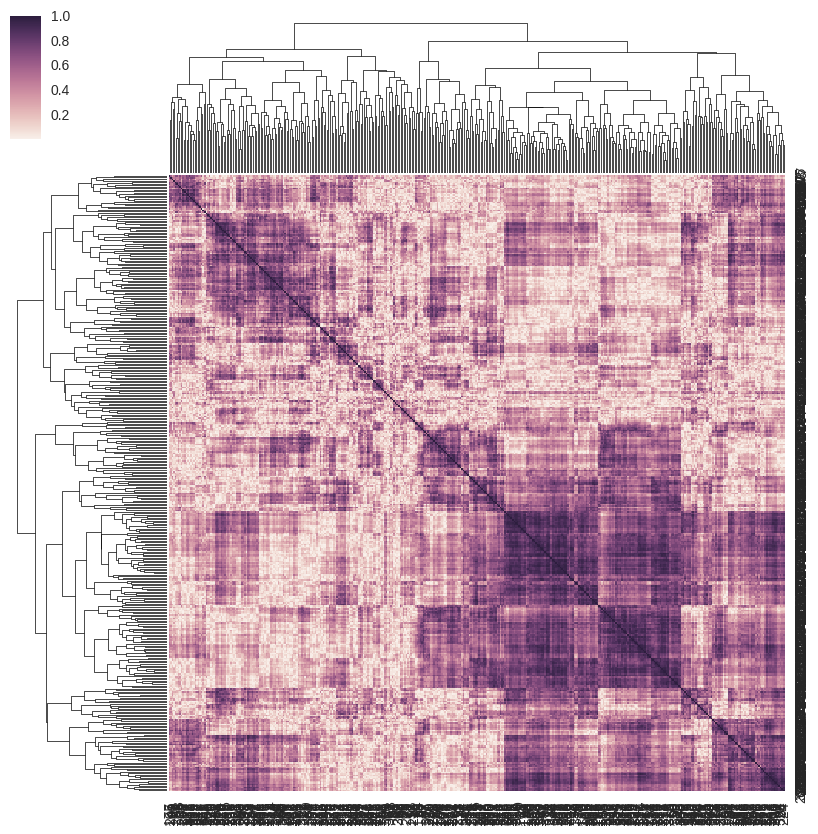

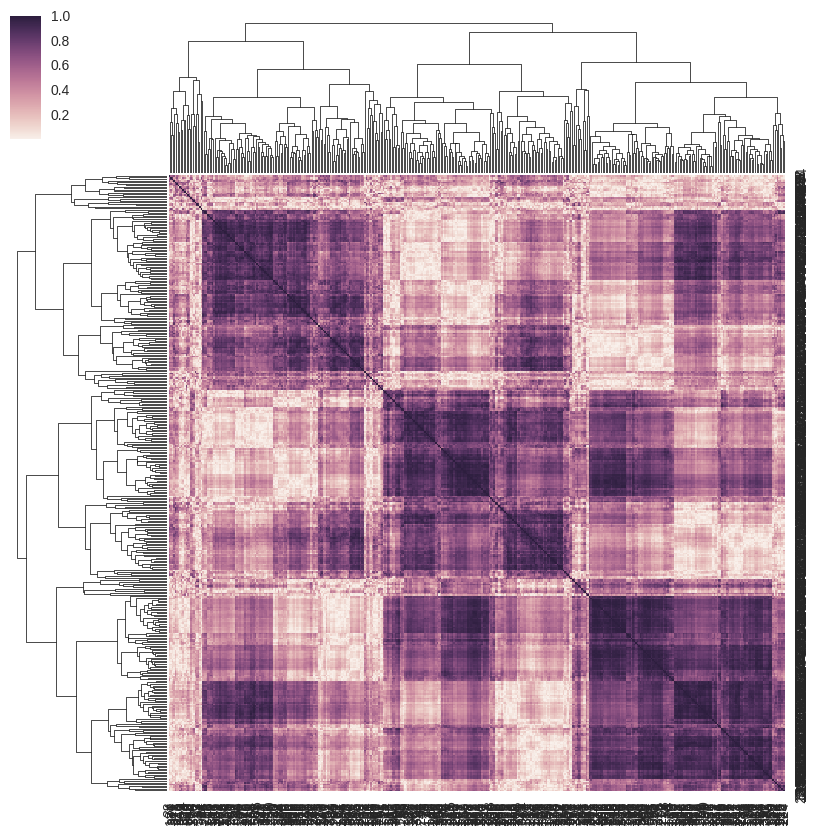

In [14]:
for  i in range(5):
    _, _, theta, x, _, _, _, _, _, beta_ = scarce_data_list[i]

    sns.clustermap(np.abs(np.corrcoef(x.T)))
    plt.show()


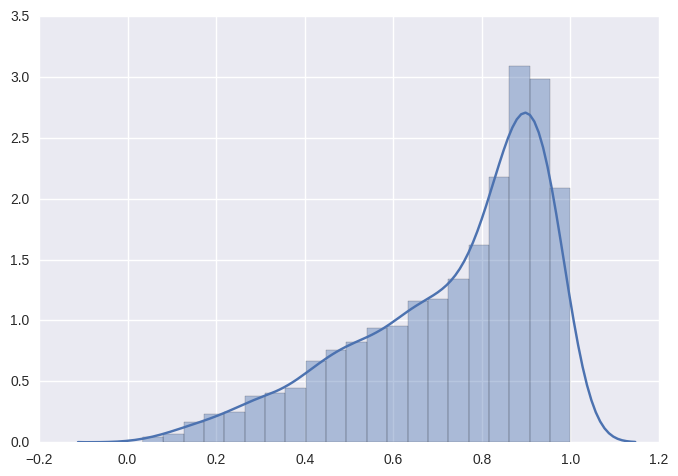

In [12]:
max_coef = np.zeros((5,400))
for  i in range(5):
    _, _, theta, x, _, _, _, _, _, beta_ = scarce_data_list[i]

    coef = np.abs(np.corrcoef(x.T))
    max_coef[i,:] = np.max(coef[np.max(np.abs(beta_),axis=0).flatten()!=0,:], axis=0)

sns.distplot(max_coef.flatten())
plt.show()


Now we train the models doing a 10 Fold Cross Validation. We train also a model using the noisy descriptors

We show the obtained Beta matrices

In [5]:
def selected_(mask_list):
    mean = np.zeros(mask_list[0].shape, dtype=np.float64)
    for mask in mask_list:
        mean += mask
    mean /= len(mask_list)
    return mean

def plot_stability(beta_list, original_beta, title):
    max_thresholds = 1000
    max_value = np.max([np.max(np.abs(beta),axis=None)for beta in beta_list], axis=None)
    selected_coordinates = []
    thresholds = np.arange(0,max_value,max_value/float(max_thresholds))
    for threshold in thresholds:
        mask_list = [np.abs(beta)>threshold for beta in beta_list]
        selected_coordinates.append(selected_(mask_list).flatten())
    
    selected_coordinates = np.array(selected_coordinates, dtype= np.float64)

    f = plt.figure(figsize=(8,8))
    for i in range(len(original_beta.flatten())):
        color = sns.xkcd_rgb['bright blue'] if original_beta.flatten()[i]==0 else sns.xkcd_rgb['orange']
        plt.plot(thresholds, selected_coordinates[:,i],color, linewidth=2)
    plt.xticks(fontsize=24)
    plt.yticks(np.arange(0,1.01,0.1),fontsize=24)

    plt.ylabel('Proportion of folds where\nthe feature is selected',fontsize=26)
    plt.xlabel('Threshold',fontsize=26)
    plt.title(title,fontsize=32)
    plt.show()

def nrmse(y_true, y_pred):
    return np.sqrt(np.sum((y_true.flatten()-y_pred.flatten())**2)/len(y_true))#/(np.max(y_true)-np.min(y_true))
def calculate_nrmse(true_ys,pred_ys):
    nrmse_vector= []
    for i in range(len(true_ys)):
        nrmse_vector.append(nrmse(true_ys[i],pred_ys[i]))
    return nrmse_vector
def mean_rocauc(real_beta, calc_beta, name, color):
    from scipy import interp
    from sklearn.metrics import roc_curve, auc
    
    mean_fpr = np.linspace(0, 1, 1000)
    acumulated= []
    mean_tpr = 0.0
    all_tpr = []
    for i in range(len(real_beta)):
        try:
            fpr, tpr, thresholds = roc_curve(np.abs(real_beta[i].flatten())>0, 
                                             (np.abs(calc_beta[i].flatten())-np.min(np.abs(calc_beta[i])))/np.max(np.abs(calc_beta[i])))
            plt.plot(fpr, tpr, color=color, lw=0.05)
            acumulated.append(list(interp(mean_fpr, fpr, tpr)))
        except:
            pass
    acumulated = np.array(acumulated)
    mean_tpr = np.mean(acumulated, axis=0)
    std_tpr = np.std(acumulated, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, label='{} Mean ROC (area = {:.2})'.format(name, mean_auc), lw=2, color=color)
    plt.fill_between(mean_fpr, mean_tpr+2*std_tpr,mean_tpr-2*std_tpr, alpha=0.1, color=color)
    return mean_tpr
def mean_prauc(real_beta, calc_beta, name, color):
    from scipy import interp
    from sklearn.metrics import precision_recall_curve, auc
    
    mean_recall = np.linspace(0, 1, 1000)
    acumulated= []
    mean_precision = 0.0
    all_tpr = []
    auc_list = []
    for i in range(len(real_beta)):
        try:
            precision, recall, thresholds = precision_recall_curve(np.abs(real_beta[i].flatten())>0, 
                                             (np.abs(calc_beta[i].flatten())-np.min(np.abs(calc_beta[i])))/np.max(np.abs(calc_beta[i])))
            args = np.argsort(recall)
            plt.plot(recall[args], precision[args], color=color, lw=.05)
            auc_list.append(auc(recall[args], precision[args]))
            acumulated.append(list(interp(mean_recall, recall[args], precision[args])))
        except:
            pass
    acumulated = np.array(acumulated)
    mean_precision = np.mean(acumulated, axis=0)
    std_precision = np.std(acumulated, axis=0)
    mean_auc = auc(mean_recall, mean_precision)
    plt.plot(mean_recall, mean_precision, label='{} Mean PR (area = {:.2})'.format(name, mean_auc), lw=2, color=color)
    plt.fill_between(mean_recall, mean_precision+2*std_precision,mean_precision-2*std_precision, alpha=0.1, color=color)

    return mean_precision

def true_positive_rate(true_betas, betas):
    return [np.sum((true_betas[i]!=0)*(betas[i]!=0))/ float(np.sum(betas[i]!=0)) for i in range(len(true_betas))]
def true_negative_rate(true_betas,betas):
    return [np.sum((true_betas[i]==0)*(betas[i]==0))/ float(np.sum(betas[i]==0)) for i in range(len(true_betas))]

def sensitivity(true_betas, betas):
    return [np.sum((true_betas[i]!=0)*(betas[i]!=0))/ float(np.sum(true_betas[i]!=0)) for i in range(len(betas))]
def specificity(true_betas, betas):
    return [np.sum((true_betas[i]==0)*(betas[i]==0))/ float(np.sum(true_betas[i]==0)) for i in range(len(betas))]


#SCARCE DATA

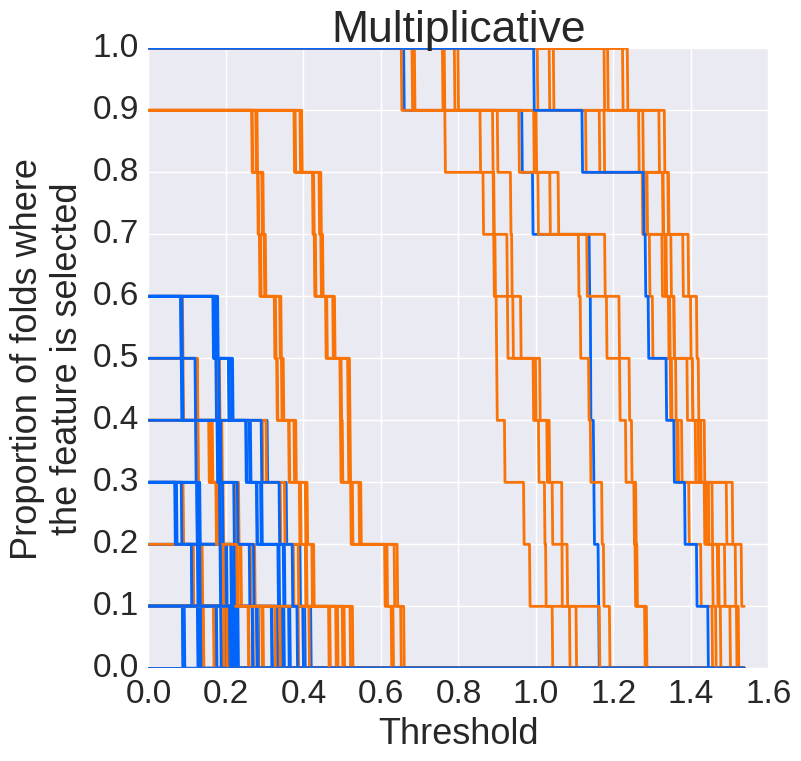

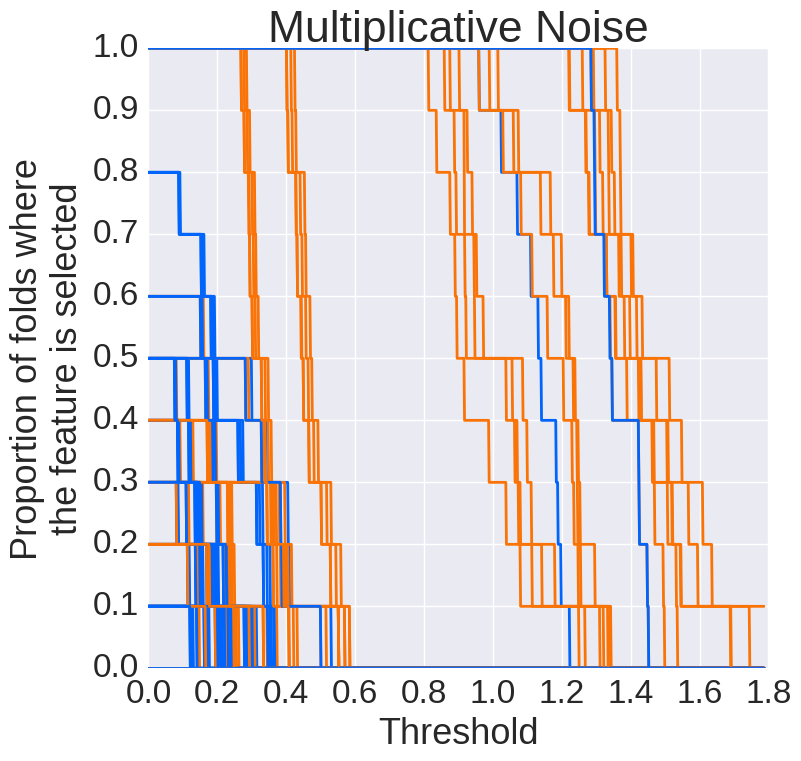

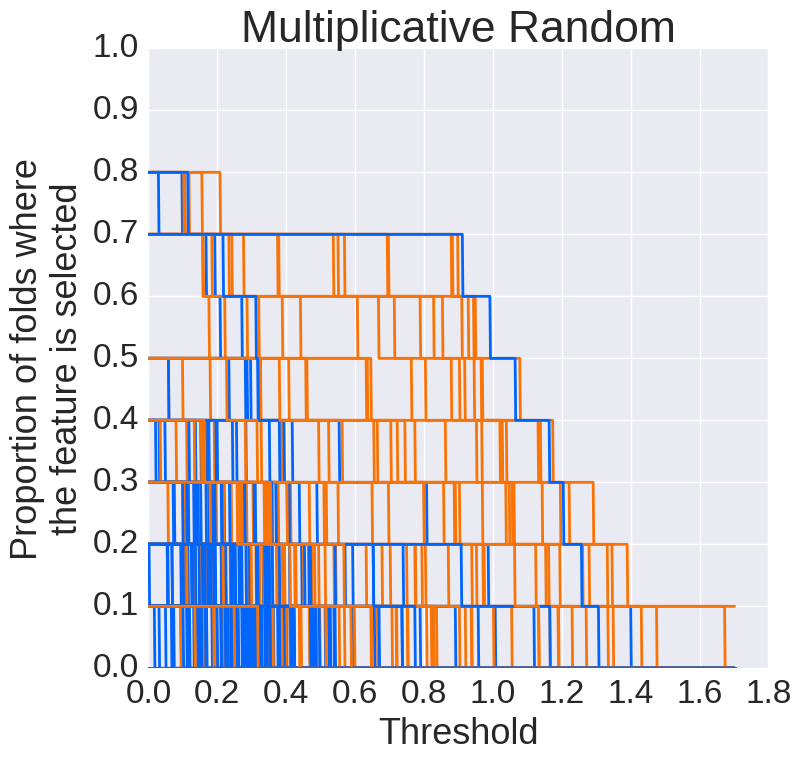

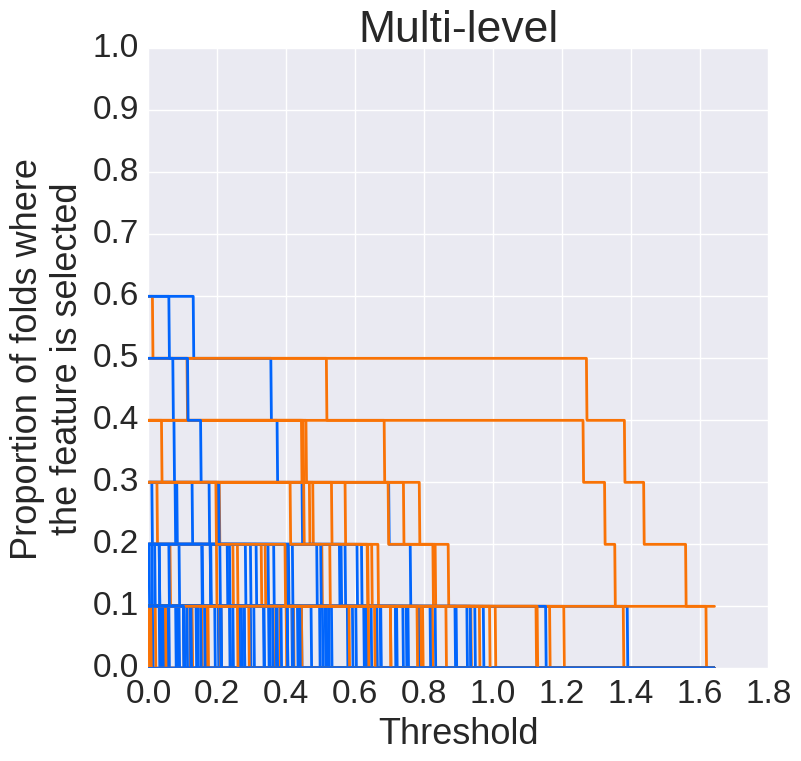

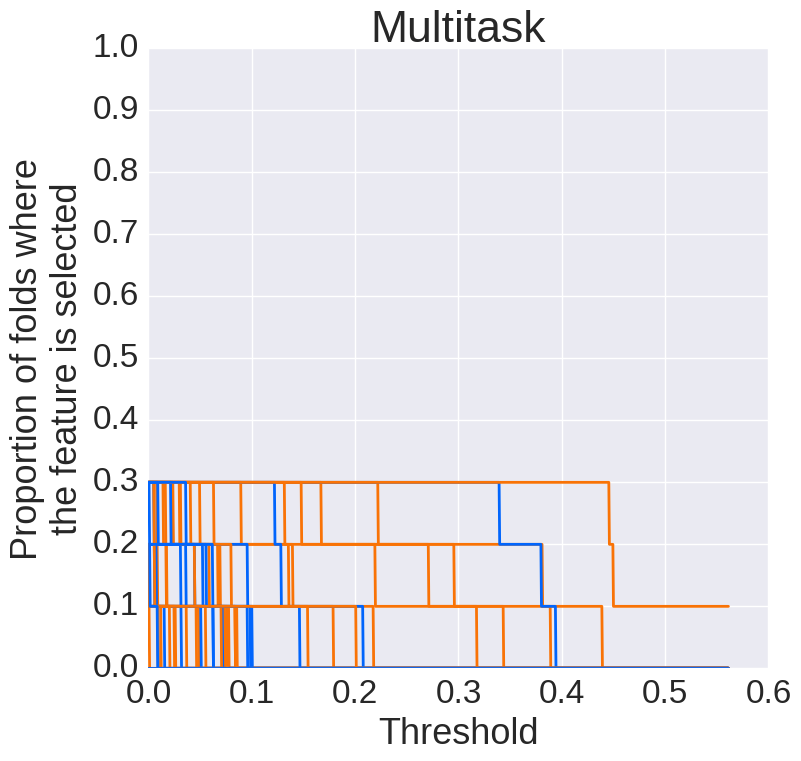

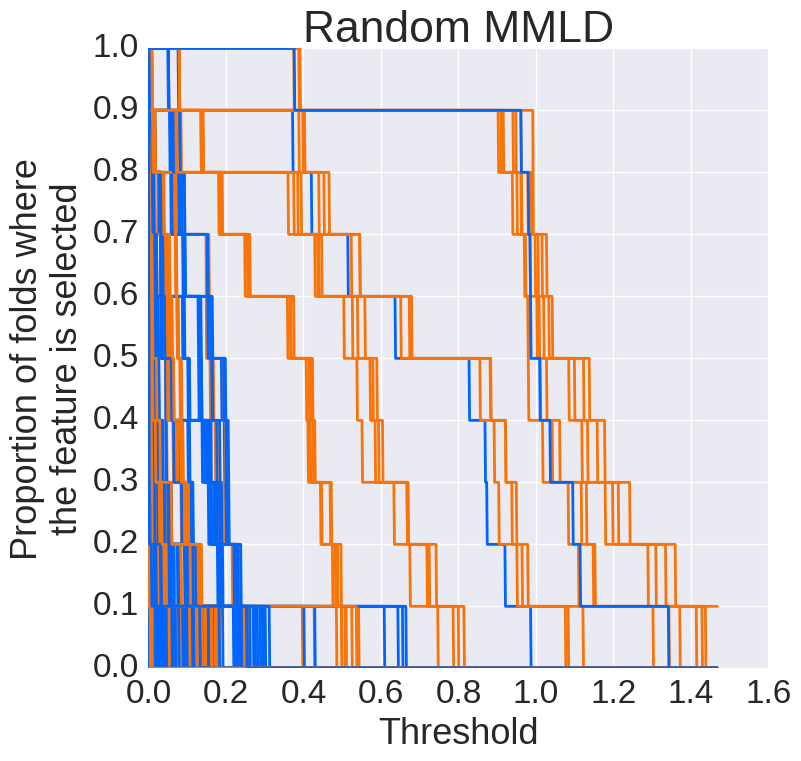

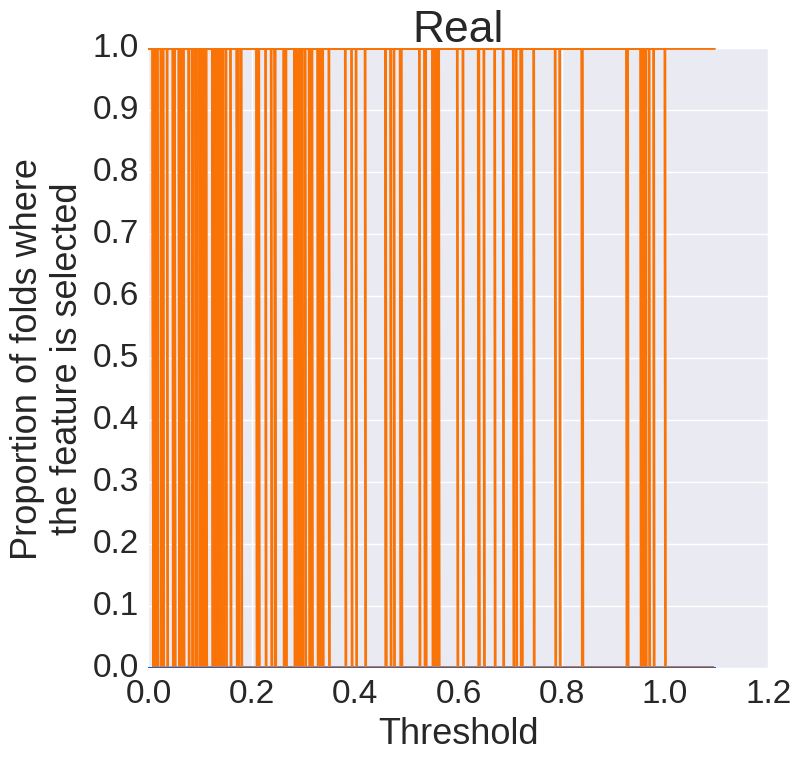

In [9]:
plot_stability(scarce_betas_bellon[0:10], scarce_beta_list[0].flatten(), 'Multiplicative')
plot_stability(scarce_betas_bellon_noise[:10], scarce_beta_list[0].flatten(), 'Multiplicative Noise')
plot_stability(scarce_betas_bellon_random[:10], scarce_beta_list[0].flatten(), 'Multiplicative Random')

plot_stability(scarce_betas_lozano[:10], scarce_beta_list[0].flatten(), 'Multi-level')
plot_stability(scarce_betas_obozinski[:10], scarce_beta_list[0].flatten(), 'Multitask')
plot_stability(scarce_betas_random[:10], scarce_beta_list[0].flatten(), 'Random MMLD')

plot_stability([scarce_beta_list[0].flatten()], scarce_beta_list[0].flatten(), 'Real')

In [6]:
scarce_betas_random[0][0]

array([  7.17851308e-04,   2.22126679e-03,  -4.52079517e-05,
         2.30971792e-03,  -4.56030563e-03,  -1.45817324e-02,
         3.51979252e-02,   1.64441618e-02,  -2.03112856e-04,
        -2.44813158e-03,   0.00000000e+00,   6.67891643e-03,
        -0.00000000e+00,  -1.23088896e-03,  -3.39565201e-03,
         9.22693033e-02,   8.83718341e-03,   5.37939590e-03,
         0.00000000e+00,   1.16120718e-02,   0.00000000e+00,
         0.00000000e+00,  -7.70223754e-03,  -3.00211207e-02,
        -3.22284136e-03,   9.68761748e-06,   4.01210132e-03,
         2.51456913e-04,  -1.53902048e-02,   7.86773079e-02,
        -5.49367401e-02,  -4.08232528e-01,   8.59134828e-02,
         0.00000000e+00,   3.29392847e-03,  -5.10699167e-02,
         7.75773602e-04,   0.00000000e+00,  -2.71800969e-02,
         8.82703781e-05,  -1.28042198e-03,   0.00000000e+00,
        -3.18586562e-02,   1.54521848e-03,   1.77993734e-02,
        -3.11968423e-04,  -8.77387920e-03,  -1.82299014e-03,
         1.58740687e-03,

Real:	100.4 \pm 2.65329983228
Multiplicative:	22.8 \pm 7.25534285889
Random:	37.12 \pm 66.0426044308


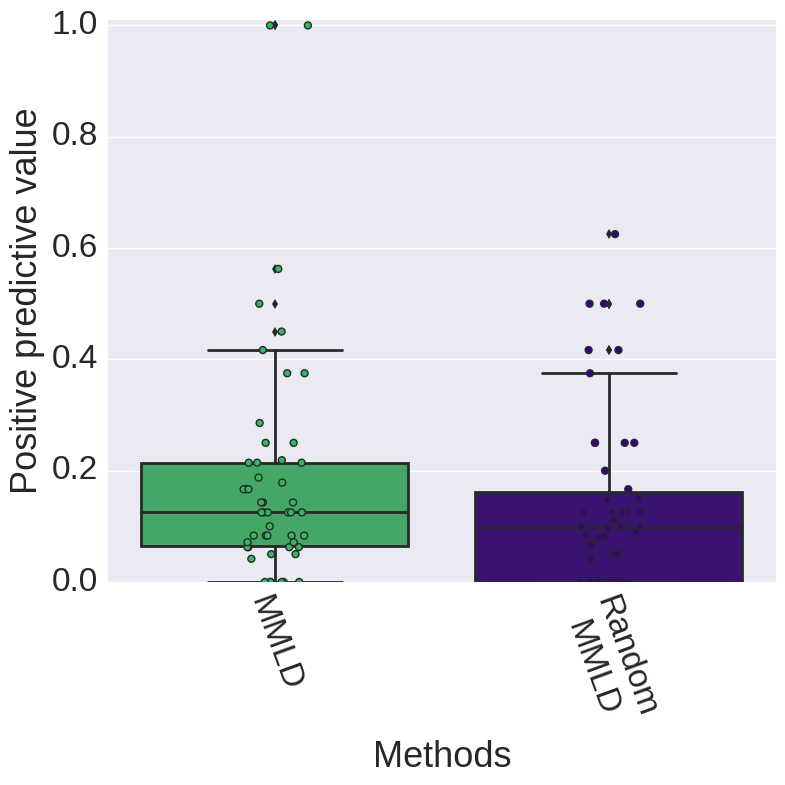

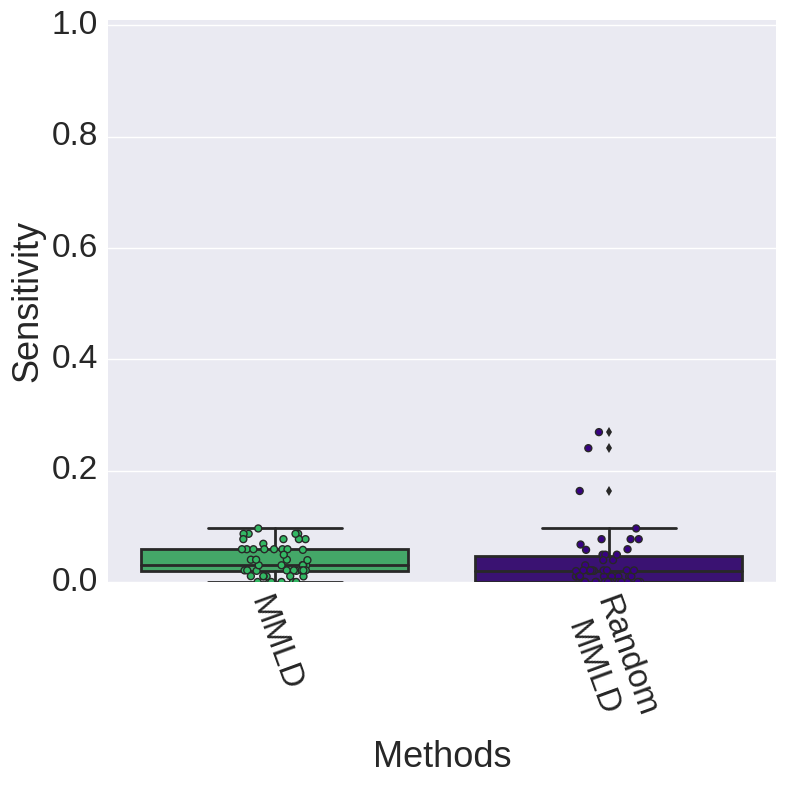

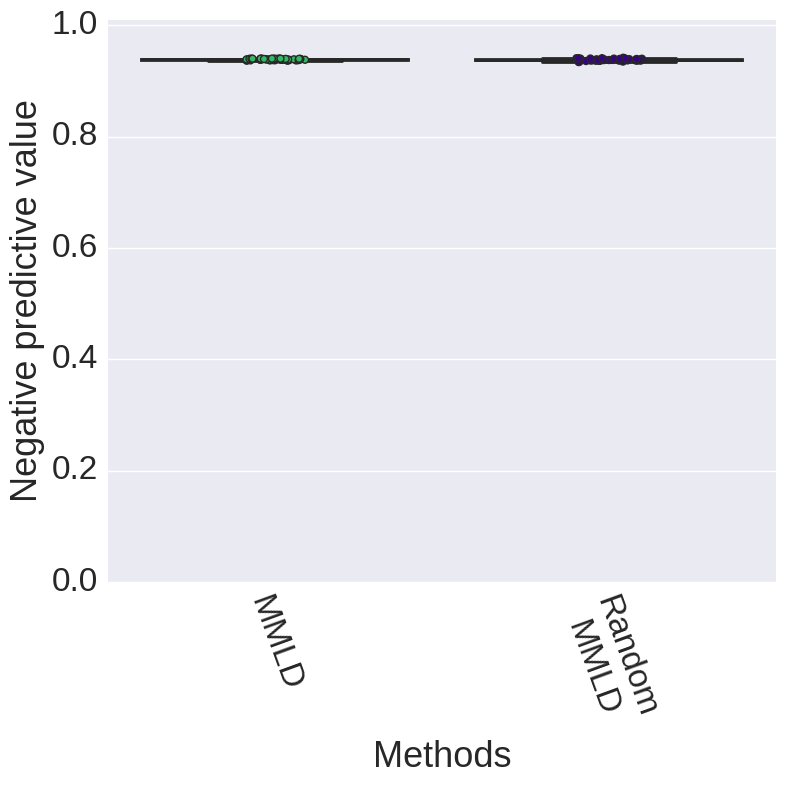

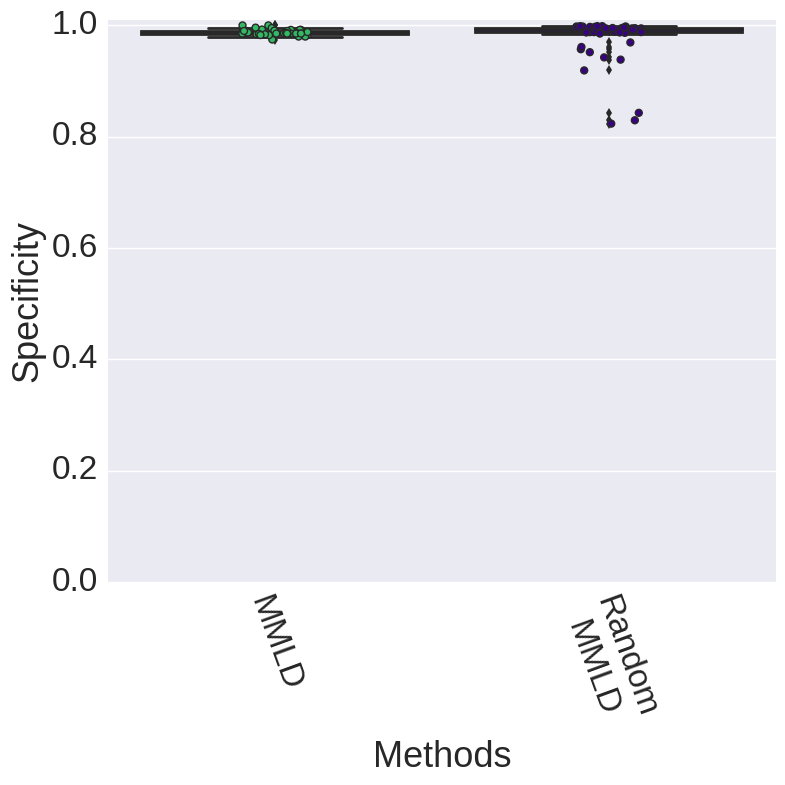

_____________________________________________________________________________________


In [6]:
reps=5
n_folds=10
true_beta = [scarce_beta_list[i] for i in range(reps) for j in range(n_folds) ]
bellon_tp = true_positive_rate(true_beta, scarce_betas_bellon)
random_tp = true_positive_rate(true_beta, scarce_betas_random)
#print random_tp
#obozinski_tp = true_positive_rate(true_beta,scarce_betas_obozinski)
#lozano_tp = true_positive_rate(true_beta, scarce_betas_lozano)
#sparse_tp = true_positive_rate(true_beta, scarce_betas_sparse)

print 'Real:\t{} \\pm {}'.format(np.mean([np.sum(bet!=0) for bet in scarce_beta_list]),np.std([np.sum(bet!=0) for bet in scarce_beta_list]))
print 'Multiplicative:\t{} \\pm {}'.format(np.mean([np.sum(bet!=0) for bet in scarce_betas_bellon]),np.std([np.sum(bet!=0) for bet in scarce_betas_bellon]))
print 'Random:\t{} \\pm {}'.format(np.mean([np.sum(bet!=0) for bet in scarce_betas_random]),np.std([np.sum(bet!=0) for bet in scarce_betas_random]))
#print 'Multitask:\t{} \\pm {}'.format(np.mean([np.sum(bet!=0) for bet in scarce_betas_obozinski]),np.std([np.sum(bet!=0) for bet in scarce_betas_obozinski]))
#print 'Sparse:\t{} \\pm {}'.format(np.mean([np.sum(bet!=0) for bet in scarce_betas_sparse]),np.std([np.sum(bet!=0) for bet in scarce_betas_sparse]))
#print 'Multilevel:\t{} \\pm {}'.format(np.mean([np.sum(bet!=0) for bet in scarce_betas_lozano]),np.std([np.sum(bet!=0) for bet in scarce_betas_lozano]))

ax = plt.figure(figsize=(8,8)).add_subplot(111)
plt.gcf().subplots_adjust(bottom=0.35, left=0.15)


sns.boxplot(data=(bellon_tp, random_tp),#obozinski_tp, sparse_tp, lozano_tp,bellon_tp, random_tp), 
            #names=('Multitask', 'Multi-level', 'Multiplicative'),#, 'Multiplicative\nNoise', 'Multiplicative\nRandom'),
            palette={0: sns.xkcd_rgb['cool green'], 1:sns.xkcd_rgb['indigo'], #2: sns.xkcd_rgb['bright blue'], 3:sns.xkcd_rgb['orange'], 
                     #4:sns.xkcd_rgb['red']
                    },
            linewidth=2
           )
sns.stripplot(data=(bellon_tp, random_tp),#obozinski_tp, sparse_tp, lozano_tp,bellon_tp, random_tp), 
            #names=('Multitask', 'Multi-level', 'Multiplicative'),#, 'Multiplicative\nNoise', 'Multiplicative\nRandom'),
            palette={0: sns.xkcd_rgb['cool green'], 1:sns.xkcd_rgb['indigo'], #2: sns.xkcd_rgb['bright blue'], 3:sns.xkcd_rgb['orange'], 
                     #4:sns.xkcd_rgb['red']
                    },
              linewidth=1, jitter=True
           )

plt.ylabel("Positive predictive value",fontsize=26)
ax.set_ylim(0,1.01)
ax.set_xticklabels(('MMLD','Random\nMMLD')) #'ML', 'MSL','MML', 'MMLD','Random\nMMLD'))
plt.xticks(fontsize=24, rotation=-70)
plt.yticks(fontsize=24)
plt.xlabel('Methods',fontsize=26)
plt.tight_layout()
plt.savefig('/home/victor/Thesis/5524838ttxbwg/Figures/Random/results/ppv_20.eps')
plt.show()

bellon_sn = sensitivity(true_beta, scarce_betas_bellon)
random_sn = sensitivity(true_beta, scarce_betas_random)
#obozinski_sn = sensitivity(true_beta,scarce_betas_obozinski)
#lozano_sn = sensitivity(true_beta, scarce_betas_lozano)
#sparse_sn = sensitivity(true_beta,scarce_betas_sparse)

ax = plt.figure(figsize=(8,8)).add_subplot(111)
plt.gcf().subplots_adjust(bottom=0.35, left=0.15)

sns.boxplot(data=(bellon_sn, random_sn),#obozinski_sn, sparse_sn, lozano_sn,bellon_sn, random_sn), 
            #names=('Multitask', 'Multi-level', 'Multiplicative'),#, 'Multiplicative\nNoise', 'Multiplicative\nRandom'),
            palette={0: sns.xkcd_rgb['cool green'], 1:sns.xkcd_rgb['indigo'], #2: sns.xkcd_rgb['bright blue'], 3:sns.xkcd_rgb['orange'], 
                     #4:sns.xkcd_rgb['red']
                    },
            linewidth=2
           )
sns.stripplot(data=(bellon_sn, random_sn), #obozinski_sn, sparse_sn,lozano_sn,bellon_sn, random_sn), 
            #names=('Multitask', 'Multi-level', 'Multiplicative'),#, 'Multiplicative\nNoise', 'Multiplicative\nRandom'),
            palette={0: sns.xkcd_rgb['cool green'], 1:sns.xkcd_rgb['indigo'], #2: sns.xkcd_rgb['bright blue'], 3:sns.xkcd_rgb['orange'], 
                     #4:sns.xkcd_rgb['red']
                    },
              linewidth=1, jitter=True
           )
plt.ylabel("Sensitivity",fontsize=26)
ax.set_ylim(0,1.01)
ax.set_xticklabels(('MMLD','Random\nMMLD')) #'ML', 'MSL','MML', 'MMLD','Random\nMMLD'))
plt.xticks(fontsize=24, rotation=-70)
plt.yticks(fontsize=24)
plt.xlabel('Methods',fontsize=26)
plt.tight_layout()
plt.savefig('/home/victor/Thesis/5524838ttxbwg/Figures/Random/results/sens_20.eps')
plt.show()

bellon_sn = true_negative_rate(true_beta, scarce_betas_bellon)
random_sn = true_negative_rate(true_beta, scarce_betas_random)
#obozinski_sn = true_negative_rate(true_beta,scarce_betas_obozinski)
#lozano_sn = true_negative_rate(true_beta, scarce_betas_lozano)
#sparse_sn = true_negative_rate(true_beta,scarce_betas_sparse)

ax = plt.figure(figsize=(8,8)).add_subplot(111)
plt.gcf().subplots_adjust(bottom=0.35, left=0.15)

sns.boxplot(data=(bellon_sn, random_sn),#obozinski_sn, sparse_sn, lozano_sn,bellon_sn, random_sn), 
            #names=('Multitask', 'Multi-level', 'Multiplicative'),#, 'Multiplicative\nNoise', 'Multiplicative\nRandom'),
            palette={0: sns.xkcd_rgb['cool green'], 1:sns.xkcd_rgb['indigo'], #2: sns.xkcd_rgb['bright blue'], 3:sns.xkcd_rgb['orange'], 
                     #4:sns.xkcd_rgb['red']
                    },
            linewidth=2
           )
sns.stripplot(data=(bellon_sn, random_sn), #obozinski_sn, sparse_sn,lozano_sn,bellon_sn, random_sn), 
            #names=('Multitask', 'Multi-level', 'Multiplicative'),#, 'Multiplicative\nNoise', 'Multiplicative\nRandom'),
            palette={0: sns.xkcd_rgb['cool green'], 1:sns.xkcd_rgb['indigo'], #2: sns.xkcd_rgb['bright blue'], 3:sns.xkcd_rgb['orange'], 
                     #4:sns.xkcd_rgb['red']
                    },
              linewidth=1, jitter=True
           )

plt.ylabel("Negative predictive value",fontsize=26)
ax.set_ylim(0,1.01)
ax.set_xticklabels(('MMLD','Random\nMMLD')) #'ML', 'MSL','MML', 'MMLD','Random\nMMLD'))
plt.xticks(fontsize=24, rotation=-70)
plt.yticks(fontsize=24)
plt.xlabel('Methods',fontsize=26)
plt.tight_layout()
plt.savefig('/home/victor/Thesis/5524838ttxbwg/Figures/Random/results/npv_20.eps')
plt.show()

bellon_sn = specificity(true_beta, scarce_betas_bellon)
random_sn = specificity(true_beta, scarce_betas_random)
#obozinski_sn = specificity(true_beta,scarce_betas_obozinski)
#lozano_sn = specificity(true_beta, scarce_betas_lozano)
#sparse_sn = specificity(true_beta,scarce_betas_sparse)

ax = plt.figure(figsize=(8,8)).add_subplot(111)
plt.gcf().subplots_adjust(bottom=0.35, left=0.15)

sns.boxplot(data=(bellon_sn, random_sn),#obozinski_sn, sparse_sn, lozano_sn,bellon_sn, random_sn), 
            #names=('Multitask', 'Multi-level', 'Multiplicative'),#, 'Multiplicative\nNoise', 'Multiplicative\nRandom'),
            palette={0: sns.xkcd_rgb['cool green'], 1:sns.xkcd_rgb['indigo'], #2: sns.xkcd_rgb['bright blue'], 3:sns.xkcd_rgb['orange'], 
                     #4:sns.xkcd_rgb['red']
                    },
            linewidth=2
           )
sns.stripplot(data=(bellon_sn, random_sn), #obozinski_sn, sparse_sn,lozano_sn,bellon_sn, random_sn), 
            #names=('Multitask', 'Multi-level', 'Multiplicative'),#, 'Multiplicative\nNoise', 'Multiplicative\nRandom'),
            palette={0: sns.xkcd_rgb['cool green'], 1:sns.xkcd_rgb['indigo'], #2: sns.xkcd_rgb['bright blue'], 3:sns.xkcd_rgb['orange'], 
                     #4:sns.xkcd_rgb['red']
                    },
              linewidth=1, jitter=True
           )

plt.ylabel("Specificity",fontsize=26)
ax.set_ylim(0,1.01)
ax.set_xticklabels(('MMLD','Random\nMMLD')) #'ML', 'MSL','MML', 'MMLD','Random\nMMLD'))
plt.xticks(fontsize=24, rotation=-70)
plt.yticks(fontsize=24)
plt.xlabel('Methods',fontsize=26)
plt.tight_layout()
plt.savefig('/home/victor/Thesis/5524838ttxbwg/Figures/Random/results/spec_20.eps')
plt.show()
print '_____________________________________________________________________________________'



In [8]:
true_beta[0].shape
scarce_betas_random[0].shape

(4, 400)

50


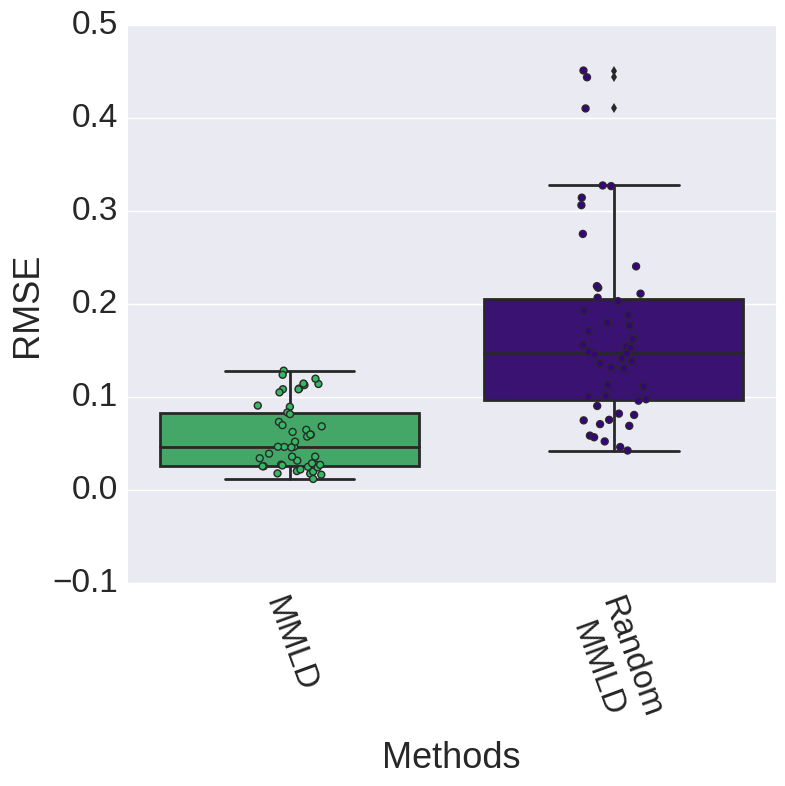

In [7]:
bellon_nrmse = calculate_nrmse(scarce_y_test, scarce_pred_bellon)
random_nrmse = calculate_nrmse(scarce_y_test, scarce_pred_random)
#obozinski_nrmse = calculate_nrmse(scarce_y_test,scarce_pred_obozinski)
#lozano_nrmse = calculate_nrmse(scarce_y_test, scarce_pred_lozano)
#sparse_nrmse = calculate_nrmse(scarce_y_test, scarce_pred_sparse)
print len(scarce_pred_random)
ax = plt.figure(figsize=(8,8)).add_subplot(111)
plt.gcf().subplots_adjust(bottom=0.35, left=0.15)
sns.boxplot(data=(bellon_nrmse, random_nrmse), #obozinski_nrmse, sparse_nrmse, lozano_nrmse,bellon_nrmse, random_nrmse), 
            #names=('Multitask', 'Multi-level', 'Multiplicative'),#, 'Multiplicative\nNoise', 'Multiplicative\nRandom'),
            palette={0: sns.xkcd_rgb['cool green'], 1:sns.xkcd_rgb['indigo'], #2: sns.xkcd_rgb['bright blue'], 3:sns.xkcd_rgb['orange'], 
                     #4:sns.xkcd_rgb['red']
                    },
            linewidth=2
           )
sns.stripplot(data=(bellon_nrmse, random_nrmse), #obozinski_nrmse, sparse_nrmse, lozano_nrmse,bellon_nrmse, random_nrmse), 
            #names=('Multitask', 'Multi-level', 'Multiplicative'),#, 'Multiplicative\nNoise', 'Multiplicative\nRandom'),
            palette={0: sns.xkcd_rgb['cool green'], 1:sns.xkcd_rgb['indigo'], #2: sns.xkcd_rgb['bright blue'], 3:sns.xkcd_rgb['orange'], 
                     #4:sns.xkcd_rgb['red']
                    },
            linewidth=1, jitter=True
           )
plt.ylabel("RMSE",fontsize=26)
ax.set_xticklabels(('MMLD','Random\nMMLD'))#'ML', 'MSL','MML', 'MMLD','Random\nMMLD'))
plt.xticks(fontsize=24, rotation=-70)
plt.yticks(fontsize=24)
plt.xlabel('Methods',fontsize=26)
plt.tight_layout()
plt.savefig('/home/victor/Thesis/5524838ttxbwg/Figures/Random/results/nrme_n20.eps')
#ax.set_ylim(0,.4)

plt.show()


In [12]:
import scipy as sp
methods_res = [('Obozinski', obozinski_nrmse), ('Sparse', sparse_nrmse), ('Lozano', lozano_nrmse), ('Bellon',bellon_nrmse),
                ('Random', random_nrmse)]
print 0.01/15.
for method1, result1 in methods_res:
    print '\n'
    for method2, result2 in methods_res:
        if method1==method2:
            continue
        t, p =sp.stats.wilcoxon(np.array(result1), y=np.array(result2))
        mean = np.mean(np.array(result1)-np.array(result2))
        std = np.std(np.array(result1)-np.array(result2))
        if p<(0.05/15.):
            print "{0} VS {1}:\tt={2:.2}\tp={3:.1}\t\t\\bf{{{4:.2}\\pm{5:.2}}}".format(method1, method2, t, p, mean, std )
        else:
            print "{0} VS {1}:\tt={2:.2}\tp={3:.1}\t\t{4:.2}\\pm{5:.2}".format(method1, method2, t, p, mean, std )

0.000666666666667


Obozinski VS Sparse:	t=1.5e+02	p=0.007		-0.025\pm0.077
Obozinski VS Lozano:	t=2.3e+02	p=0.009		-0.032\pm0.076
Obozinski VS Bellon:	t=4.6e+01	p=2e-08		\bf{0.13\pm0.11}
Obozinski VS Random:	t=7e+01	p=4e-08		\bf{0.096\pm0.091}


Sparse VS Obozinski:	t=1.5e+02	p=0.007		0.025\pm0.077
Sparse VS Lozano:	t=3.8e+02	p=0.7		-0.0069\pm0.075
Sparse VS Bellon:	t=2.5e+01	p=5e-09		\bf{0.15\pm0.11}
Sparse VS Random:	t=3.2e+01	p=5e-09		\bf{0.12\pm0.093}


Lozano VS Obozinski:	t=2.3e+02	p=0.009		0.032\pm0.076
Lozano VS Sparse:	t=3.8e+02	p=0.7		0.0069\pm0.075
Lozano VS Bellon:	t=1.4e+01	p=2e-09		\bf{0.16\pm0.11}
Lozano VS Random:	t=1.6e+01	p=2e-09		\bf{0.13\pm0.088}


Bellon VS Obozinski:	t=4.6e+01	p=2e-08		\bf{-0.13\pm0.11}
Bellon VS Sparse:	t=2.5e+01	p=5e-09		\bf{-0.15\pm0.11}
Bellon VS Lozano:	t=1.4e+01	p=2e-09		\bf{-0.16\pm0.11}
Bellon VS Random:	t=2.7e+02	p=0.0004		\bf{-0.03\pm0.057}


Random VS Obozinski:	t=7e+01	p=4e-08		\bf{-0.096\pm0.091}
Random VS Sparse:	t=3.2e+01	p=5e-09		\

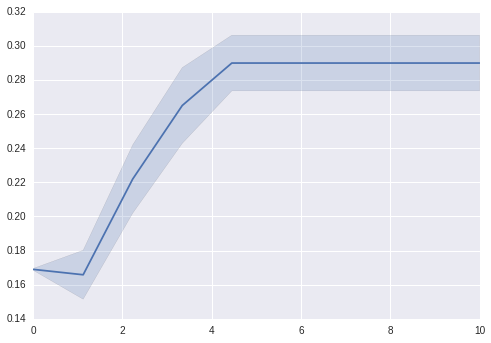

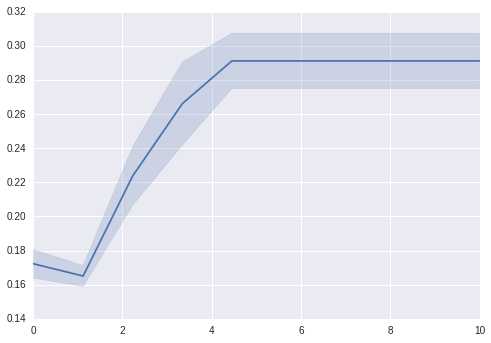

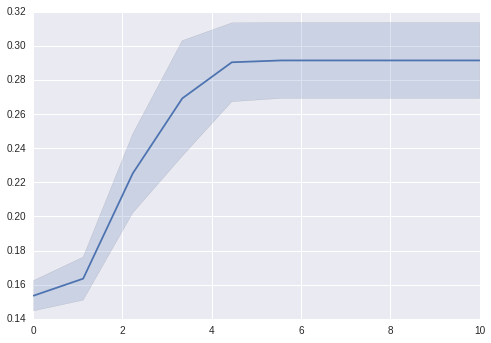

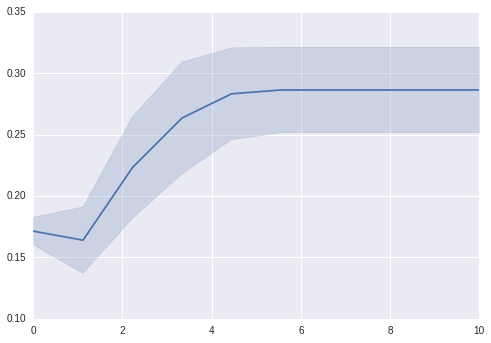

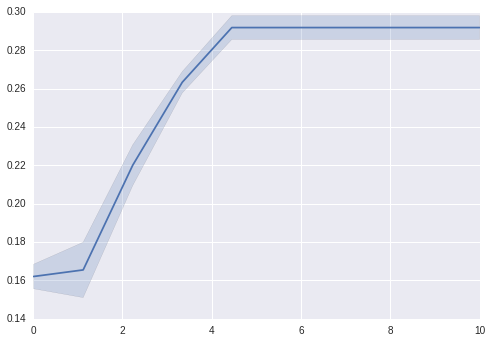

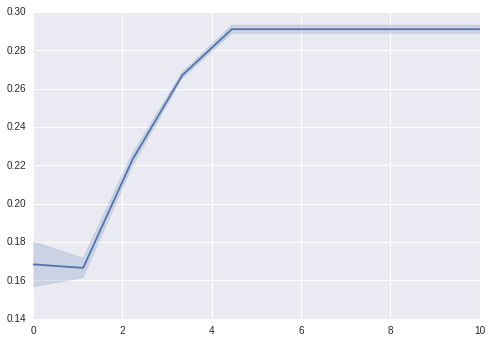

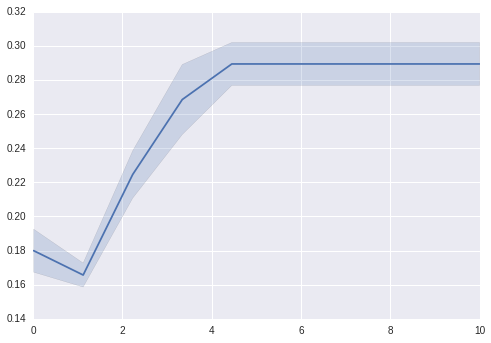

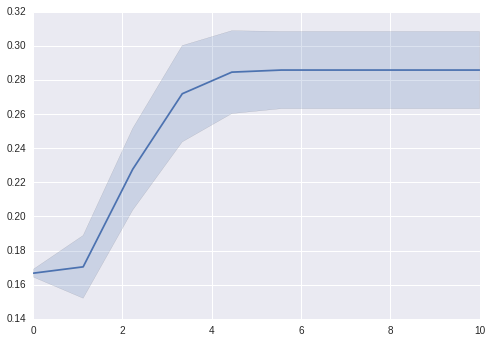

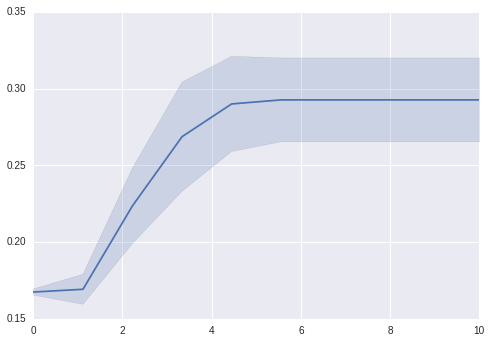

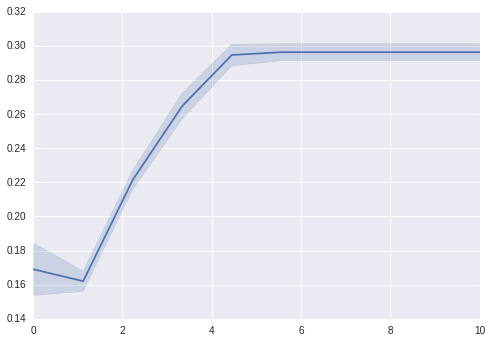

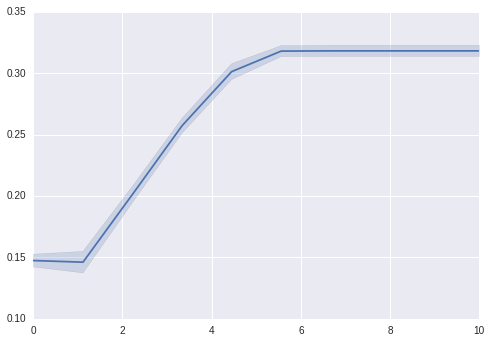

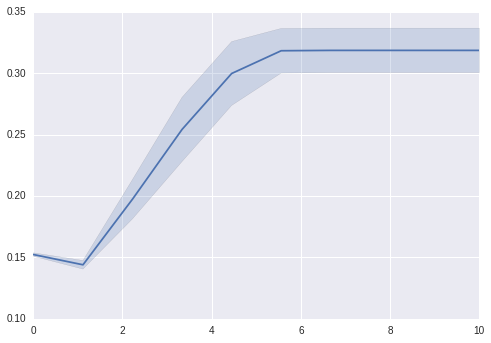

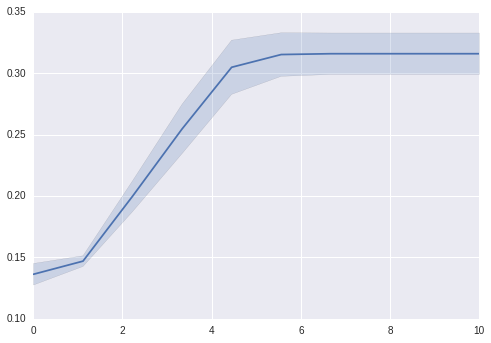

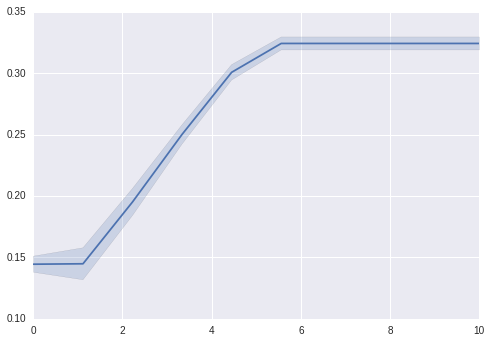

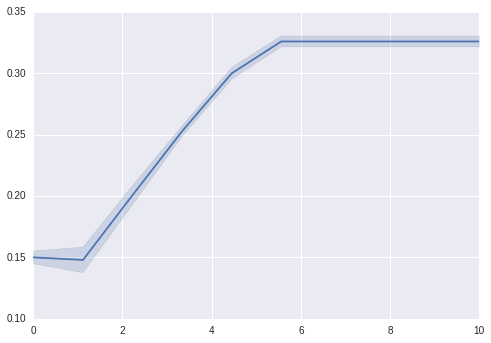

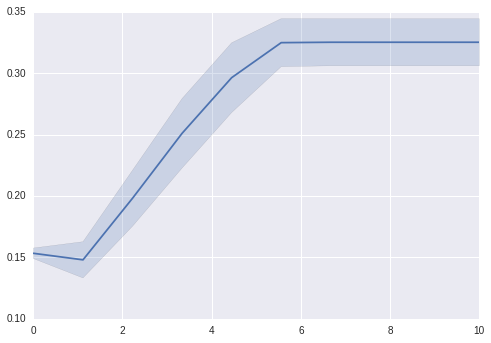

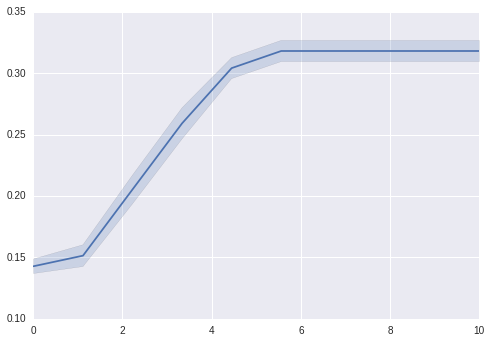

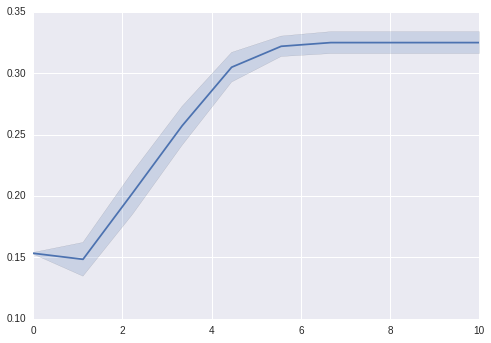

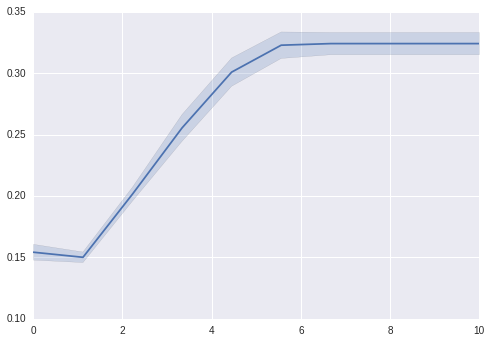

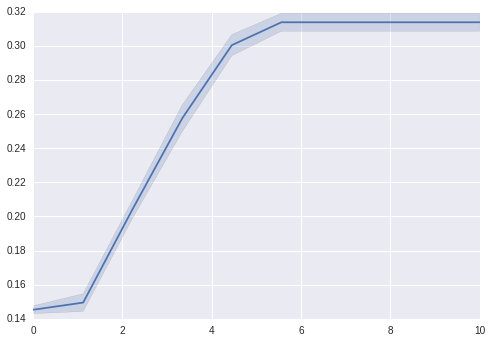

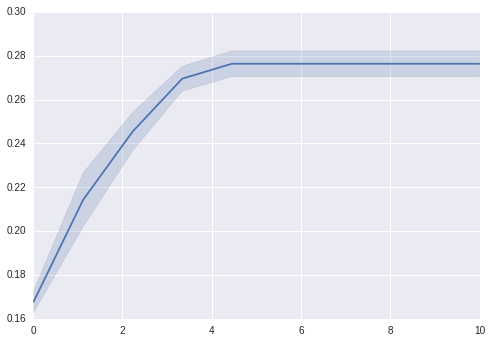

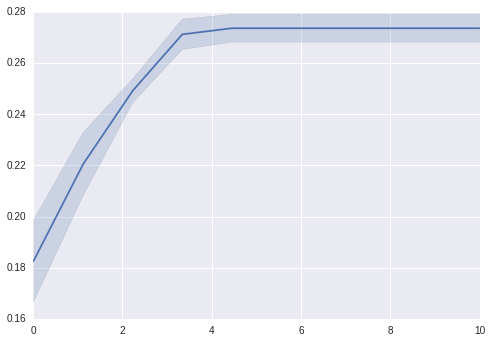

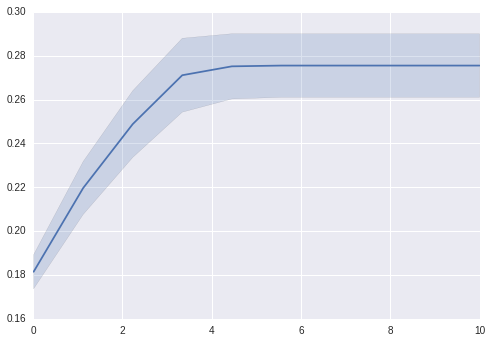

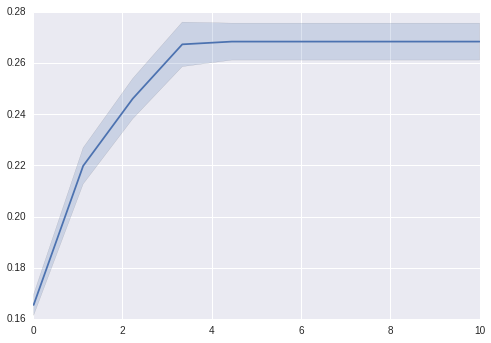

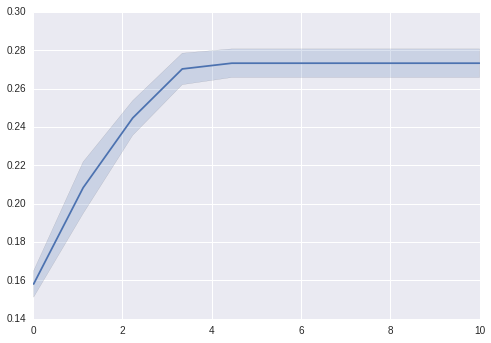

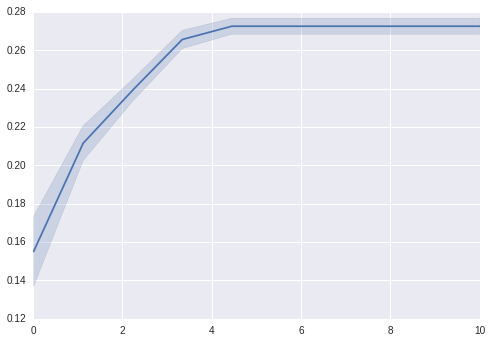

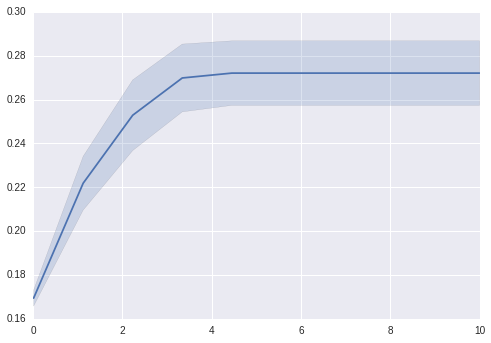

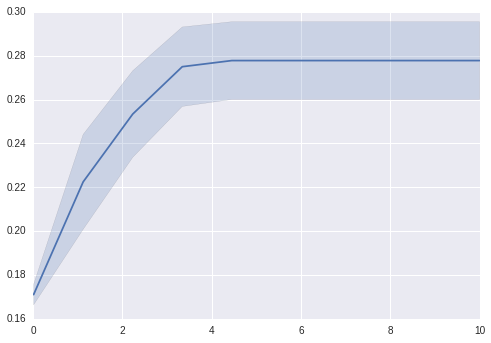

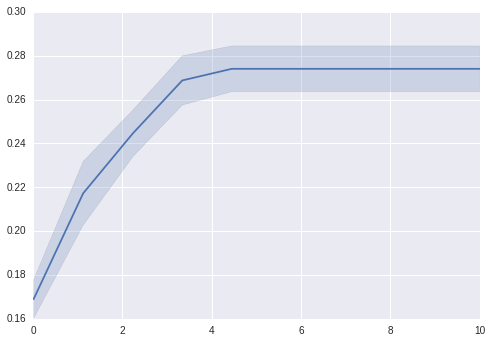

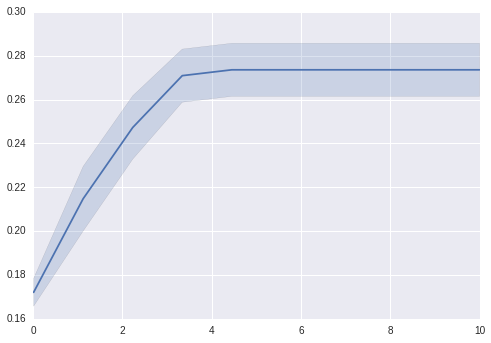

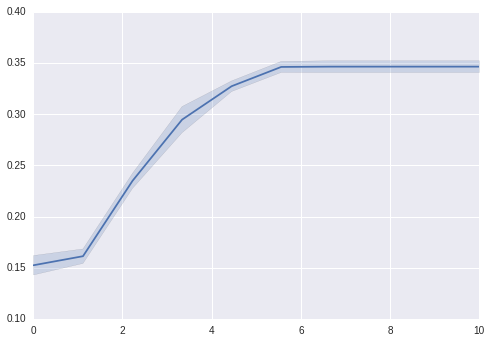

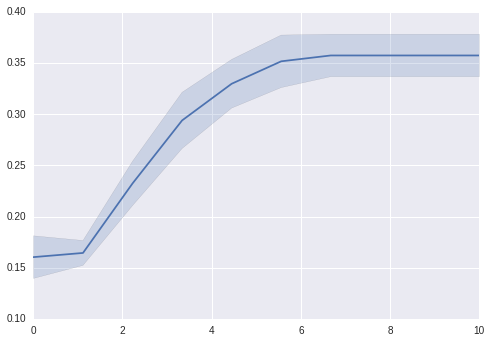

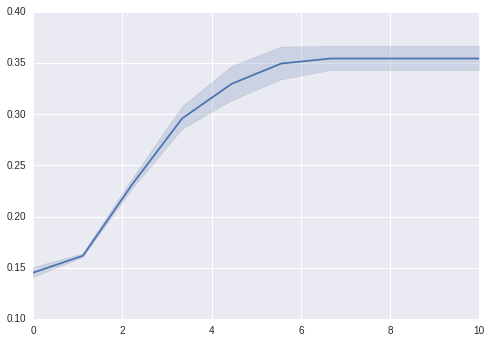

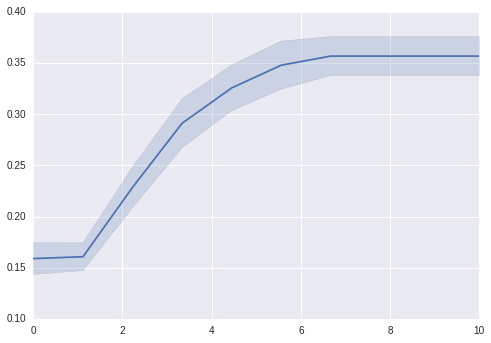

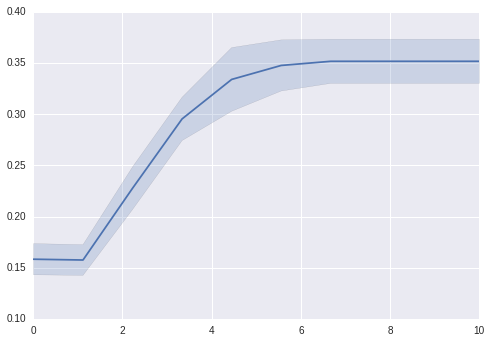

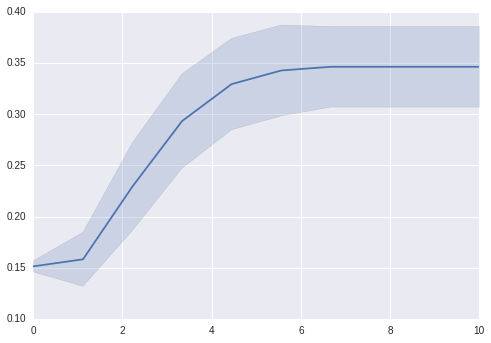

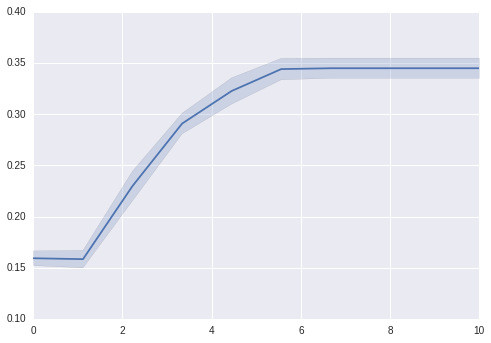

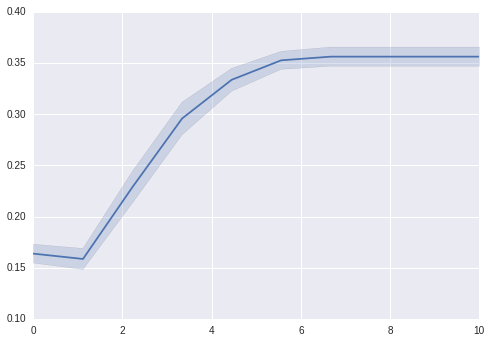

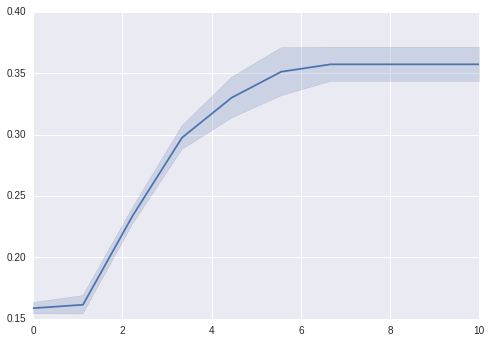

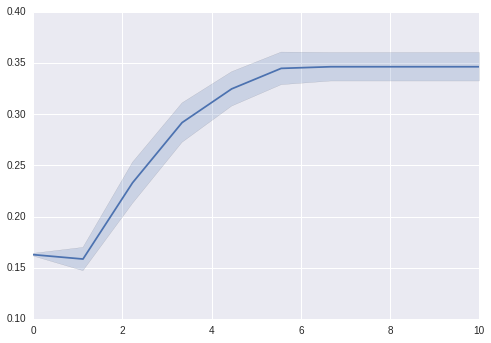

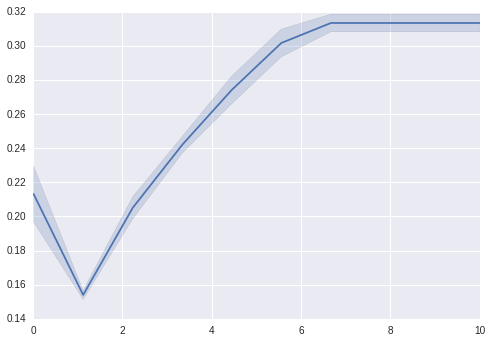

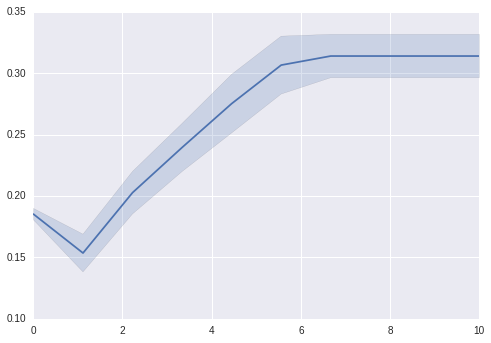

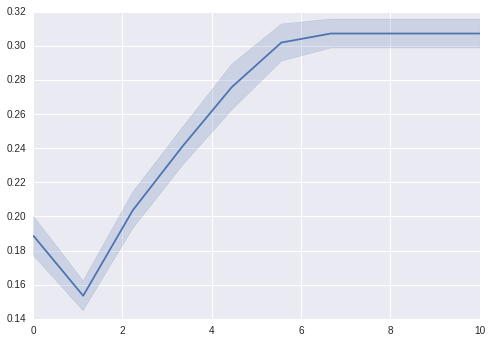

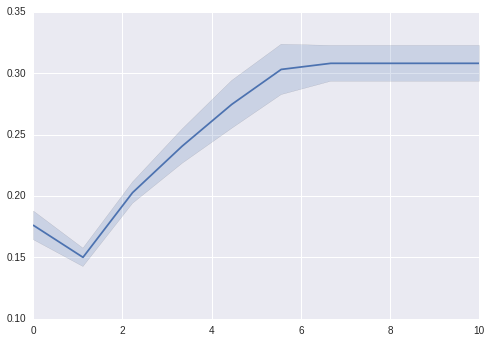

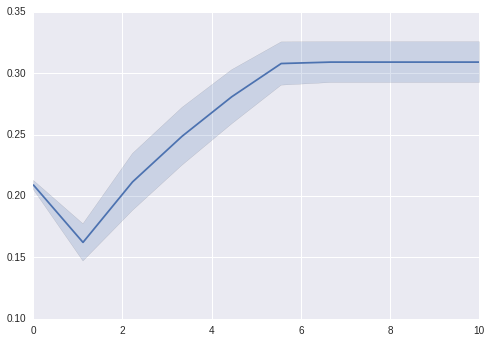

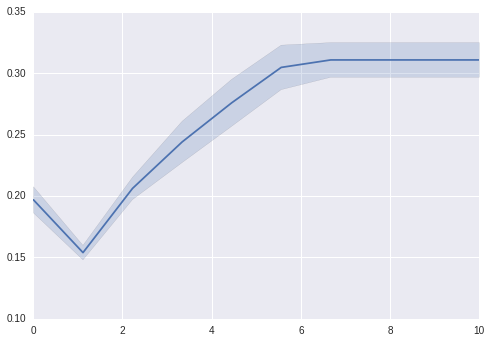

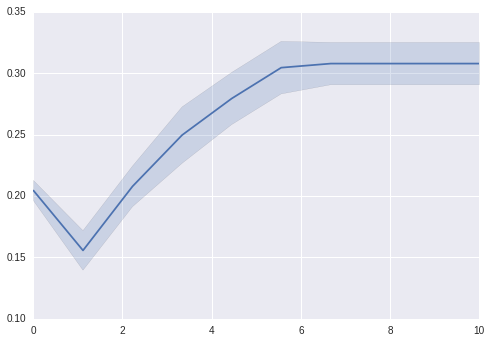

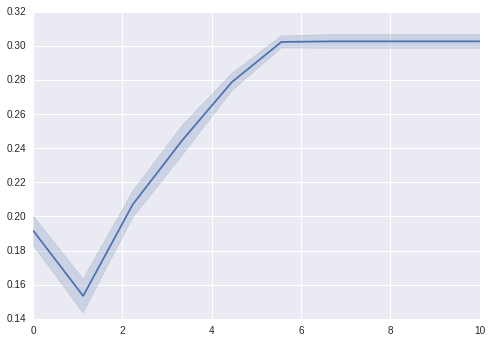

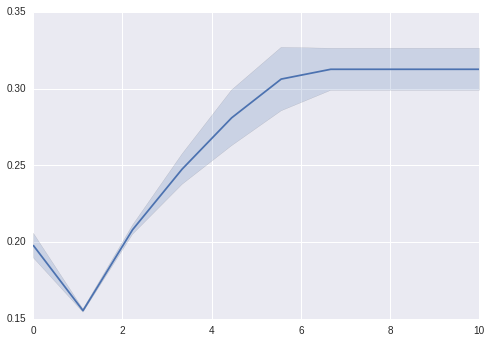

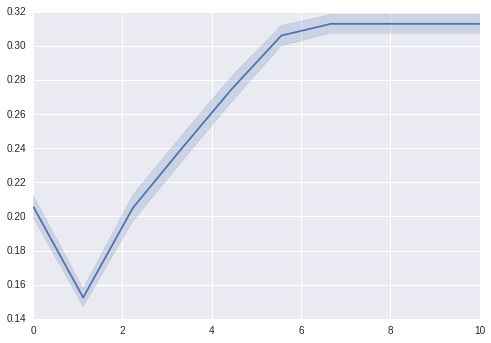

In [28]:
#print path.keys()
len(scarce_path_obozinski)
for i in range(50):
    f = plt.figure()
    path = normal_path_obozinski[i]
    scores = np.array(path['scores'])
    params = path['params']
    std = np.array(path['std_scores'])
    
    pars = [par['lambda_1'] for par in params]
    plt.plot(pars,scores)
    
    plt.fill_between(pars, scores+std, scores-std, alpha=0.2)
    plt.show()

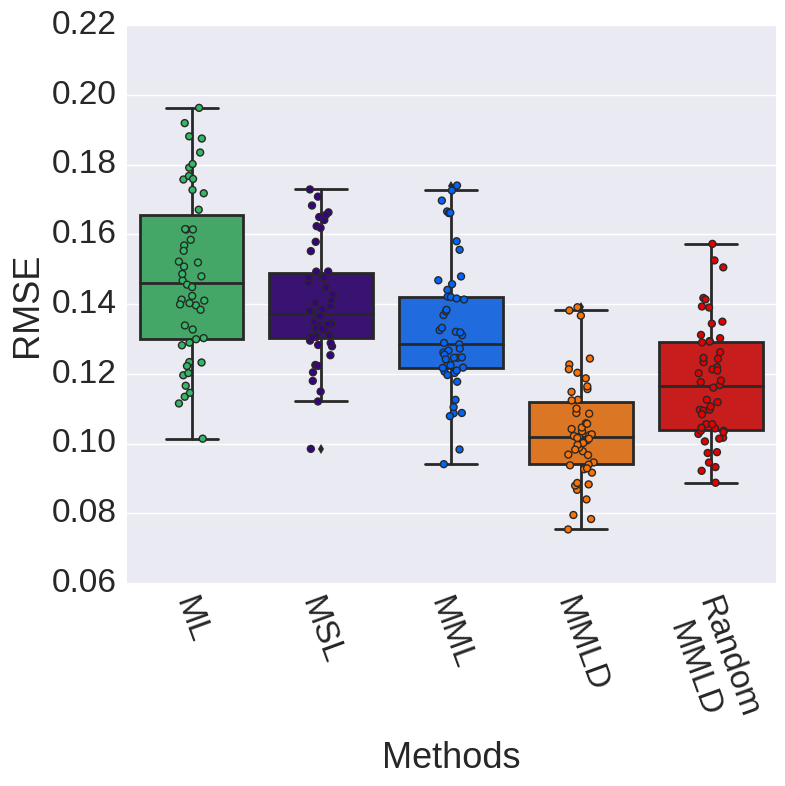

In [13]:
bellon_nrmse = calculate_nrmse(normal_y_test, normal_pred_bellon)
random_nrmse = calculate_nrmse(normal_y_test, normal_pred_random)
obozinski_nrmse = calculate_nrmse(normal_y_test,normal_pred_obozinski)
sparse_nrmse = calculate_nrmse(normal_y_test,normal_pred_sparse)
lozano_nrmse = calculate_nrmse(normal_y_test, normal_pred_lozano)

ax = plt.figure(figsize=(8,8)).add_subplot(111)
plt.gcf().subplots_adjust(bottom=0.35, left=0.15)
sns.boxplot(data=(obozinski_nrmse, sparse_nrmse, lozano_nrmse,bellon_nrmse, random_nrmse), 
            #names=('Multitask', 'Multi-level', 'Multiplicative'),#, 'Multiplicative\nNoise', 'Multiplicative\nRandom'),
           palette={0: sns.xkcd_rgb['cool green'], 1:sns.xkcd_rgb['indigo'], 2: sns.xkcd_rgb['bright blue'], 3:sns.xkcd_rgb['orange'], 
                     4:sns.xkcd_rgb['red']},
            linewidth=2
           )
sns.stripplot(data=(obozinski_nrmse, sparse_nrmse, lozano_nrmse,bellon_nrmse, random_nrmse), 
            #names=('Multitask', 'Multi-level', 'Multiplicative'),#, 'Multiplicative\nNoise', 'Multiplicative\nRandom'),
           palette={0: sns.xkcd_rgb['cool green'], 1:sns.xkcd_rgb['indigo'], 2: sns.xkcd_rgb['bright blue'], 3:sns.xkcd_rgb['orange'], 
                     4:sns.xkcd_rgb['red']},
            linewidth=1, jitter=True
           )
plt.ylabel("RMSE",fontsize=26)
ax.set_xticklabels(('ML', 'MSL','MML', 'MMLD','Random\nMMLD'))
plt.xticks(fontsize=24, rotation=-70)
plt.yticks(fontsize=24)
plt.xlabel('Methods',fontsize=26)
plt.tight_layout()
plt.savefig('/home/victor/Thesis/5524838ttxbwg/Figures/Random/results/nrme_n100.eps')

plt.show()




In [14]:
import scipy as sp
methods_res = [('Obozinski', obozinski_nrmse), ('Sparse', sparse_nrmse), ('Lozano', lozano_nrmse), ('Bellon',bellon_nrmse),
               ('Random', random_nrmse)]
print 0.01/15.
for method1, result1 in methods_res:
    print '\n'
    for method2, result2 in methods_res:
        if method1==method2:
            continue
        t, p =sp.stats.wilcoxon(np.array(result1), y=np.array(result2))
        mean = np.mean(np.array(result1)-np.array(result2))
        std = np.std(np.array(result1)-np.array(result2))
        if p<(0.05/15.):
            print "{0} VS {1}:\tt={2:.2}\tp={3:.1}\t\t\\bf{{{4:.2}\\pm{5:.2}}}".format(method1, method2, t, p, mean, std )
        else:
            print "{0} VS {1}:\tt={2:.2}\tp={3:.1}\t\t{4:.2}\\pm{5:.2}".format(method1, method2, t, p, mean, std )

0.000666666666667


Obozinski VS Sparse:	t=4.2e+02	p=0.04		0.0085\pm0.019
Obozinski VS Lozano:	t=1.3e+02	p=9e-07		\bf{0.016\pm0.019}
Obozinski VS Bellon:	t=0.0	p=8e-10		\bf{0.045\pm0.025}
Obozinski VS Random:	t=2.3e+01	p=3e-09		\bf{0.031\pm0.025}


Sparse VS Obozinski:	t=4.2e+02	p=0.04		-0.0085\pm0.019
Sparse VS Lozano:	t=3.6e+02	p=0.007		0.007\pm0.017
Sparse VS Bellon:	t=0.0	p=8e-10		\bf{0.036\pm0.018}
Sparse VS Random:	t=6.2e+01	p=3e-08		\bf{0.023\pm0.02}


Lozano VS Obozinski:	t=1.3e+02	p=9e-07		\bf{-0.016\pm0.019}
Lozano VS Sparse:	t=3.6e+02	p=0.007		-0.007\pm0.017
Lozano VS Bellon:	t=2.0	p=9e-10		\bf{0.029\pm0.019}
Lozano VS Random:	t=1.5e+02	p=2e-06		\bf{0.016\pm0.019}


Bellon VS Obozinski:	t=0.0	p=8e-10		\bf{-0.045\pm0.025}
Bellon VS Sparse:	t=0.0	p=8e-10		\bf{-0.036\pm0.018}
Bellon VS Lozano:	t=2.0	p=9e-10		\bf{-0.029\pm0.019}
Bellon VS Random:	t=1.7e+01	p=2e-09		\bf{-0.014\pm0.011}


Random VS Obozinski:	t=2.3e+01	p=3e-09		\bf{-0.031\pm0.025}
Random VS Sparse:	t=6.2e+01	p=3e-

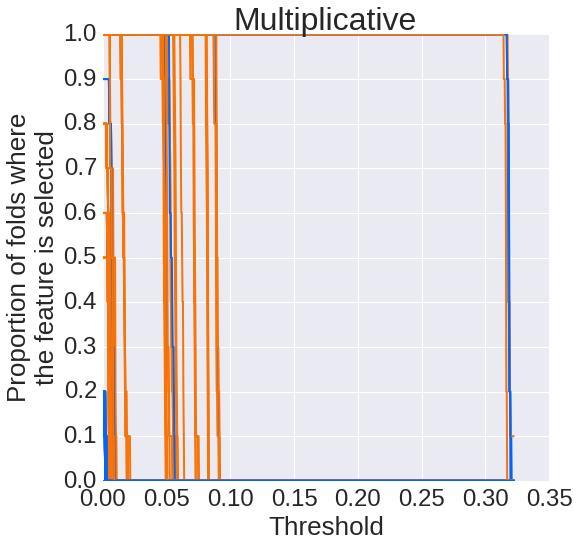

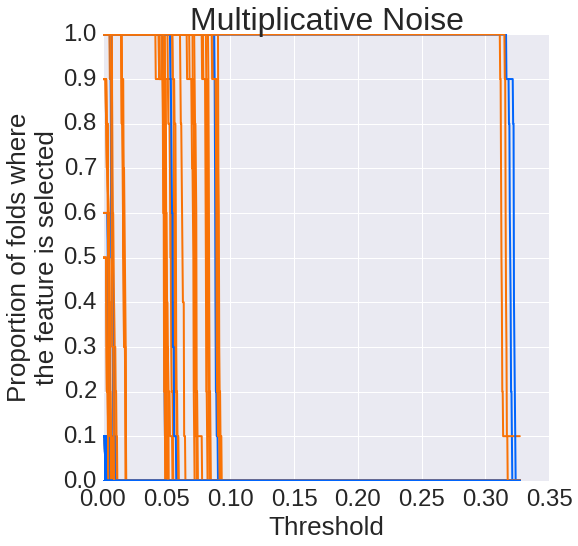

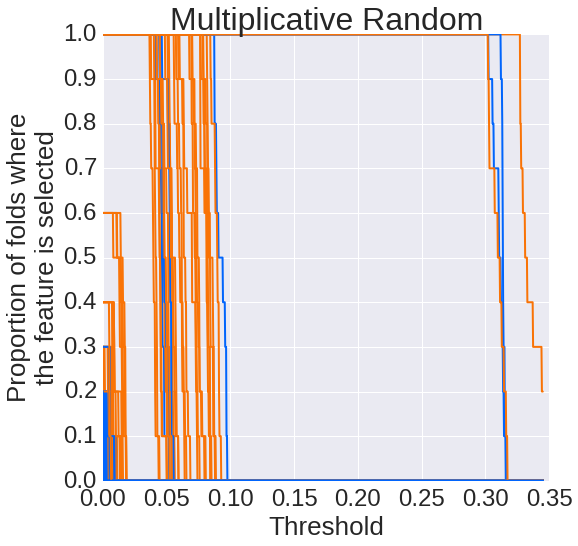

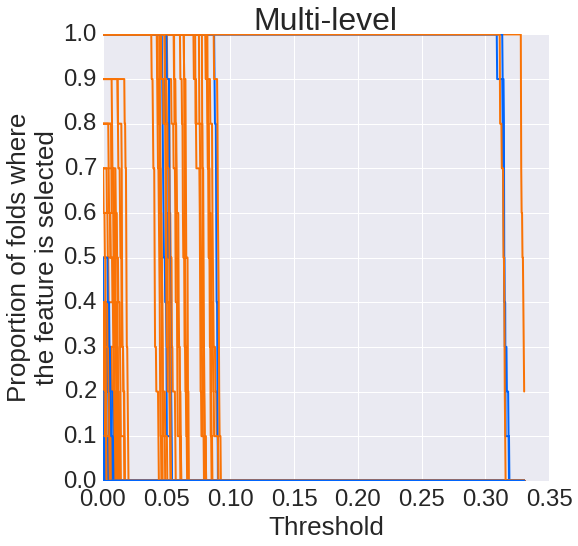

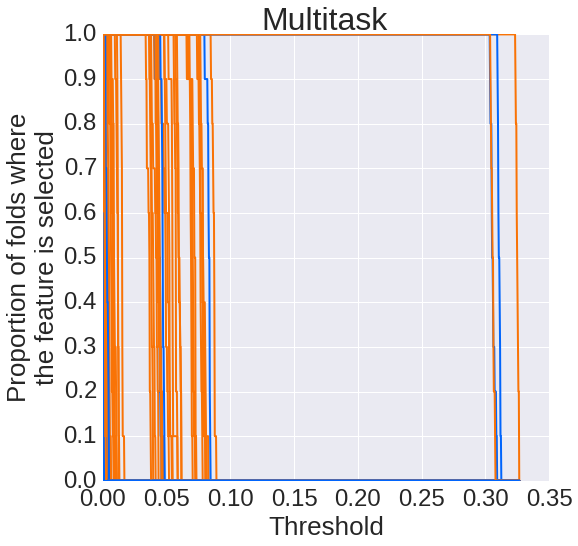

In [19]:
plot_stability(normal_betas_bellon[:10], normal_beta_list[0].flatten(), 'Multiplicative' )
plot_stability(normal_betas_bellon_noise[:10], normal_beta_list[0].flatten(), 'Multiplicative Noise' )
plot_stability(normal_betas_bellon_random[:10], normal_beta_list[0].flatten(), 'Multiplicative Random' )

plot_stability(normal_betas_lozano[:10], normal_beta_list[0].flatten(), 'Multi-level')
plot_stability(normal_betas_obozinski[:10], normal_beta_list[0].flatten(), 'Multitask')

Real:	126.8 \pm 6.88186021363
Multiplicative:	54.88 \pm 9.86436009075
Noise:	56.88 \pm 11.2082826517
Random:	49.12 \pm 56.4725207512
Multitask:	169.28 \pm 163.457522311
SparseMultitask:	231.62 \pm 121.308349259
Multilevel:	83.9 \pm 80.7389001659


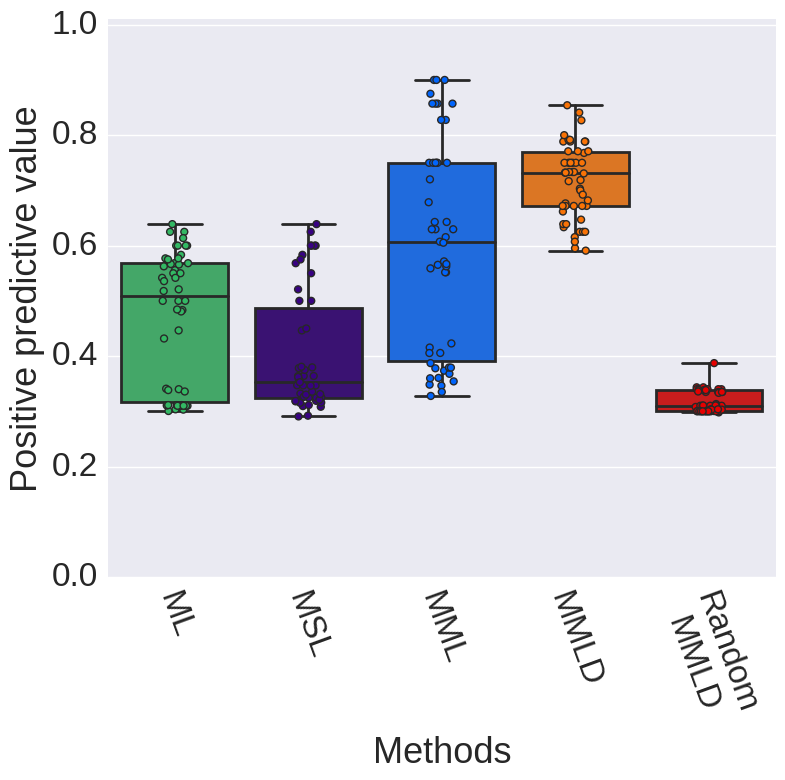

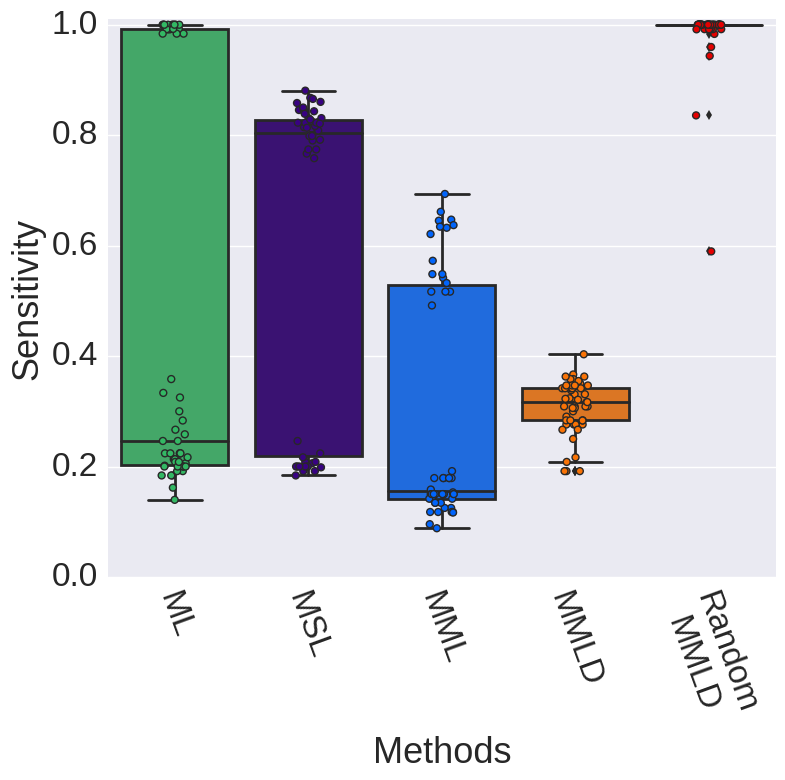

 /home/victor/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:92: RuntimeWarning:invalid value encountered in divide


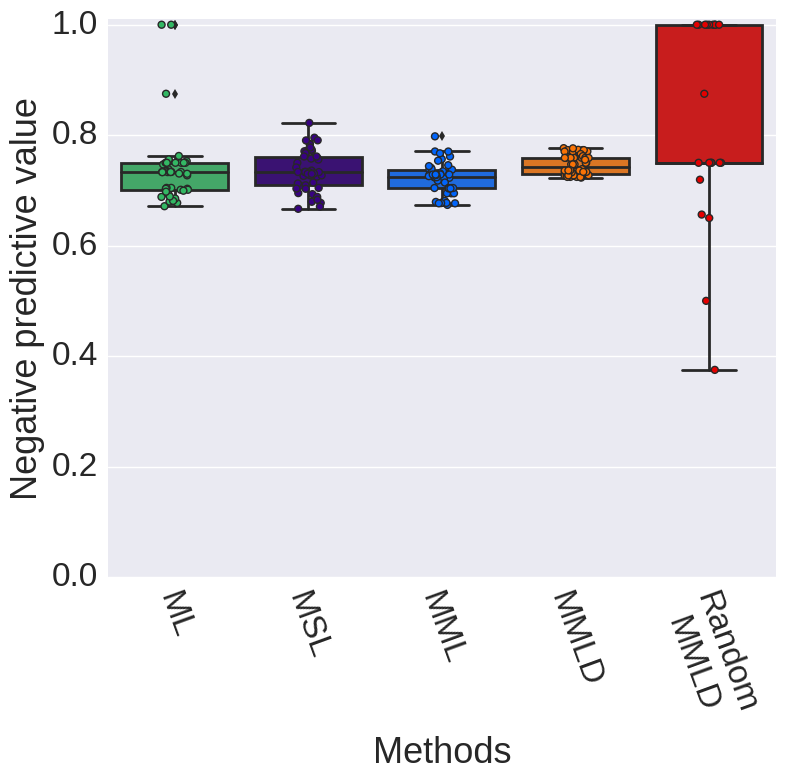

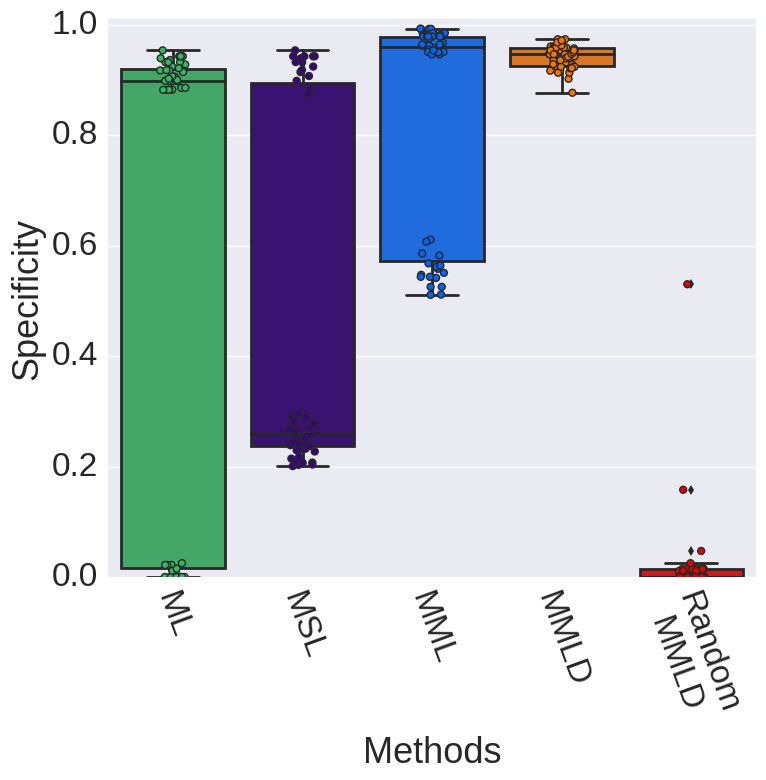

In [15]:
true_beta = [normal_beta_list[i] for i in range(5) for j in range(10) ]
bellon_tp = true_positive_rate(true_beta, normal_betas_bellon)
random_tp = true_positive_rate(true_beta, normal_betas_random)
obozinski_tp = true_positive_rate(true_beta, normal_betas_obozinski)
lozano_tp = true_positive_rate(true_beta, normal_betas_lozano)
sparse_tp = true_positive_rate(true_beta, normal_betas_sparse)

print 'Real:\t{} \\pm {}'.format(np.mean([np.sum(bet!=0) for bet in normal_beta_list]), np.std([np.sum(bet!=0) for bet in normal_beta_list]))
print 'Multiplicative:\t{} \\pm {}'.format(np.mean([np.sum(bet!=0) for bet in normal_betas_bellon]),np.std([np.sum(bet!=0) for bet in normal_betas_bellon]))
print 'Noise:\t{} \\pm {}'.format(np.mean([np.sum(bet!=0) for bet in normal_betas_bellon_noise]),np.std([np.sum(bet!=0) for bet in normal_betas_bellon_noise]))
print 'Random:\t{} \\pm {}'.format(np.mean([np.sum(bet!=0) for bet in normal_betas_bellon_random]),np.std([np.sum(bet!=0) for bet in normal_betas_bellon_random]))
print 'Multitask:\t{} \\pm {}'.format(np.mean([np.sum(bet!=0) for bet in normal_betas_obozinski]),np.std([np.sum(bet!=0) for bet in normal_betas_obozinski]))
print 'SparseMultitask:\t{} \\pm {}'.format(np.mean([np.sum(bet!=0) for bet in normal_betas_sparse]),np.std([np.sum(bet!=0) for bet in normal_betas_sparse]))
print 'Multilevel:\t{} \\pm {}'.format(np.mean([np.sum(bet!=0) for bet in normal_betas_lozano]),np.std([np.sum(bet!=0) for bet in normal_betas_lozano]))

ax = plt.figure(figsize=(8,8)).add_subplot(111)
plt.gcf().subplots_adjust(bottom=0.35, left=0.15)
sns.boxplot(data=(obozinski_tp,sparse_tp, lozano_tp,bellon_tp, random_tp), 
            #names=('Multitask', 'Multi-level', 'Multiplicative'),#, 'Multiplicative\nNoise', 'Multiplicative\nRandom'),
           palette={0: sns.xkcd_rgb['cool green'], 1:sns.xkcd_rgb['indigo'], 2: sns.xkcd_rgb['bright blue'], 3:sns.xkcd_rgb['orange'], 
                     4:sns.xkcd_rgb['red']},
            linewidth=2
           )
sns.stripplot(data=(obozinski_tp,sparse_tp,lozano_tp,bellon_tp, random_tp), 
            #names=('Multitask', 'Multi-level', 'Multiplicative'),#, 'Multiplicative\nNoise', 'Multiplicative\nRandom'),
           palette={0: sns.xkcd_rgb['cool green'], 1:sns.xkcd_rgb['indigo'], 2: sns.xkcd_rgb['bright blue'], 3:sns.xkcd_rgb['orange'], 
                     4:sns.xkcd_rgb['red']},
            linewidth=1, jitter=True
           )
plt.ylabel("Positive predictive value",fontsize=26)
ax.set_xticklabels(('ML', 'MSL','MML', 'MMLD','Random\nMMLD'))
plt.xticks(fontsize=24, rotation=-70)
plt.yticks(fontsize=24)
plt.xlabel('Methods',fontsize=26)
plt.tight_layout()
ax.set_ylim(0,1.01)

plt.savefig('/home/victor/Thesis/5524838ttxbwg/Figures/Random/results/ppv_100.eps')
plt.show()


bellon_tp = sensitivity(true_beta, normal_betas_bellon)
random_tp = sensitivity(true_beta, normal_betas_random)
obozinski_tp = sensitivity(true_beta, normal_betas_obozinski)
lozano_tp = sensitivity(true_beta, normal_betas_lozano)
sparse_tp = sensitivity(true_beta, normal_betas_sparse)

ax = plt.figure(figsize=(8,8)).add_subplot(111)
plt.gcf().subplots_adjust(bottom=0.35, left=0.15)
sns.boxplot(data=(obozinski_tp,sparse_tp,lozano_tp,bellon_tp, random_tp), 
            #names=('Multitask', 'Multi-level', 'Multiplicative'),#, 'Multiplicative\nNoise', 'Multiplicative\nRandom'),
           palette={0: sns.xkcd_rgb['cool green'], 1:sns.xkcd_rgb['indigo'], 2: sns.xkcd_rgb['bright blue'], 3:sns.xkcd_rgb['orange'], 
                     4:sns.xkcd_rgb['red']},
            linewidth=2
           )
sns.stripplot(data=(obozinski_tp, sparse_tp,lozano_tp,bellon_tp, random_tp), 
            #names=('Multitask', 'Multi-level', 'Multiplicative'),#, 'Multiplicative\nNoise', 'Multiplicative\nRandom'),
           palette={0: sns.xkcd_rgb['cool green'], 1:sns.xkcd_rgb['indigo'], 2: sns.xkcd_rgb['bright blue'], 3:sns.xkcd_rgb['orange'], 
                     4:sns.xkcd_rgb['red']},
            linewidth=1, jitter=True
           )
plt.ylabel("Sensitivity",fontsize=26)
ax.set_xticklabels(('ML', 'MSL','MML', 'MMLD','Random\nMMLD'))
plt.xticks(fontsize=24, rotation=-70)
plt.yticks(fontsize=24)
plt.xlabel('Methods',fontsize=26)
plt.tight_layout()
ax.set_ylim(0,1.01)

plt.savefig('/home/victor/Thesis/5524838ttxbwg/Figures/Random/results/sens_100.eps')
plt.show()

true_beta = [normal_beta_list[i] for i in range(5) for j in range(10) ]
bellon_tp = true_negative_rate(true_beta, normal_betas_bellon)
random_tp = true_negative_rate(true_beta, normal_betas_random)
obozinski_tp = true_negative_rate(true_beta, normal_betas_obozinski)
lozano_tp = true_negative_rate(true_beta, normal_betas_lozano)
sparse_tp = true_negative_rate(true_beta, normal_betas_sparse)


ax = plt.figure(figsize=(8,8)).add_subplot(111)
plt.gcf().subplots_adjust(bottom=0.35, left=0.15)
sns.boxplot(data=(obozinski_tp,sparse_tp,lozano_tp,bellon_tp, random_tp), 
            #names=('Multitask', 'Multi-level', 'Multiplicative'),#, 'Multiplicative\nNoise', 'Multiplicative\nRandom'),
           palette={0: sns.xkcd_rgb['cool green'], 1:sns.xkcd_rgb['indigo'], 2: sns.xkcd_rgb['bright blue'], 3:sns.xkcd_rgb['orange'], 
                     4:sns.xkcd_rgb['red']},
            linewidth=2
           )
sns.stripplot(data=(obozinski_tp,sparse_tp,lozano_tp,bellon_tp, random_tp), 
            #names=('Multitask', 'Multi-level', 'Multiplicative'),#, 'Multiplicative\nNoise', 'Multiplicative\nRandom'),
           palette={0: sns.xkcd_rgb['cool green'], 1:sns.xkcd_rgb['indigo'], 2: sns.xkcd_rgb['bright blue'], 3:sns.xkcd_rgb['orange'], 
                     4:sns.xkcd_rgb['red']},
            linewidth=1, jitter=True
           )
plt.ylabel("Negative predictive value",fontsize=26)
ax.set_xticklabels(('ML', 'MSL','MML', 'MMLD','Random\nMMLD'))
plt.xticks(fontsize=24, rotation=-70)
plt.yticks(fontsize=24)
plt.xlabel('Methods',fontsize=26)
plt.tight_layout()
ax.set_ylim(0,1.01)

plt.savefig('/home/victor/Thesis/5524838ttxbwg/Figures/Random/results/npv_100.eps')
plt.show()


bellon_tp = specificity(true_beta, normal_betas_bellon)
random_tp = specificity(true_beta, normal_betas_random)
obozinski_tp = specificity(true_beta, normal_betas_obozinski)
lozano_tp = specificity(true_beta, normal_betas_lozano)
sparse_tp = specificity(true_beta, normal_betas_sparse)


ax = plt.figure(figsize=(8,8)).add_subplot(111)
plt.gcf().subplots_adjust(bottom=0.35, left=0.15)
sns.boxplot(data=(obozinski_tp,sparse_tp,lozano_tp,bellon_tp, random_tp), 
            #names=('Multitask', 'Multi-level', 'Multiplicative'),#, 'Multiplicative\nNoise', 'Multiplicative\nRandom'),
           palette={0: sns.xkcd_rgb['cool green'], 1:sns.xkcd_rgb['indigo'], 2: sns.xkcd_rgb['bright blue'], 3:sns.xkcd_rgb['orange'], 
                     4:sns.xkcd_rgb['red']},
            linewidth=2
           )
sns.stripplot(data=(obozinski_tp,sparse_tp,lozano_tp,bellon_tp, random_tp), 
            #names=('Multitask', 'Multi-level', 'Multiplicative'),#, 'Multiplicative\nNoise', 'Multiplicative\nRandom'),
           palette={0: sns.xkcd_rgb['cool green'], 1:sns.xkcd_rgb['indigo'], 2: sns.xkcd_rgb['bright blue'], 3:sns.xkcd_rgb['orange'], 
                     4:sns.xkcd_rgb['red']},
            linewidth=1, jitter=True
           )
plt.ylabel("Specificity",fontsize=26)
ax.set_xticklabels(('ML', 'MSL','MML', 'MMLD','Random\nMMLD'))
plt.xticks(fontsize=24, rotation=-70)
plt.yticks(fontsize=24)
plt.xlabel('Methods',fontsize=26)
plt.tight_layout()
ax.set_ylim(0,1.01)

plt.savefig('/home/victor/Thesis/5524838ttxbwg/Figures/Random/results/spec_100.eps')
plt.show()



[0.494949494949495, 0.494949494949495, 1.0, 0.24050632911392406, -0.010101010101010102, -0.010101010101010102, 0.24050632911392406, 0.494949494949495, 0.7468354430379747, 0.49748743718592964, 1.0, -0.012658227848101266, 1.0, -0.005025125628140704, -0.012658227848101266, -0.005025125628140704, 0.4936708860759494, 1.0, 0.4936708860759494, -0.005025125628140704, -0.005025125628140704, -0.012658227848101266, -0.005025125628140704, -0.012658227848101266, -0.012658227848101266, -0.002506265664160401, -0.005025125628140704, -0.012658227848101266, -0.005025125628140704, -0.012658227848101266, -0.012658227848101266, -0.012658227848101266, 0.189873417721519, 0.4936708860759494, 0.189873417721519, -0.005025125628140704, -0.012658227848101266, -0.005025125628140704, 1.0, 1.0, -0.005025125628140704, -0.012658227848101266, -0.012658227848101266, 0.189873417721519, 0.4936708860759494, -0.005025125628140704, -0.007556675062972292, 0.49622166246851385, -0.005025125628140704, 0.49748743718592964, -0.005

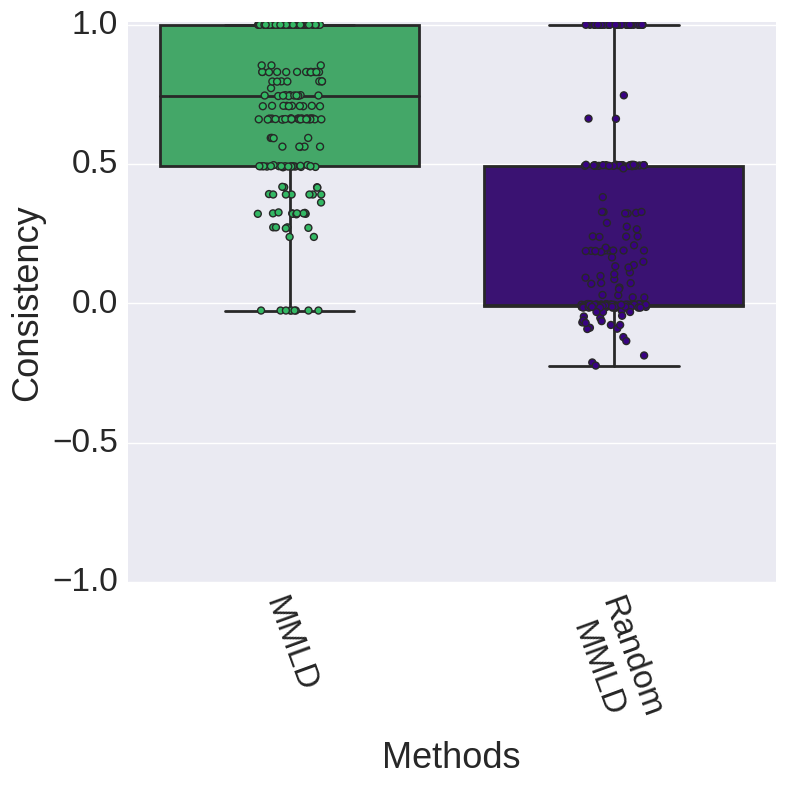

In [8]:
def consistency_index(sets, thr=0, normalize=False):
    ic_list = []
    n_set = len(sets)
    for i in range(n_set):
        if normalize:
            set_a = np.abs(sets[i]).flatten()/np.max(np.abs(sets[i]).flatten()) > thr
        else:
            set_a = np.abs(sets[i]).flatten() > thr
        size_a = np.sum(set_a)
        n = len(set_a)
        for j in range(i+1, n_set):
            if normalize:
                set_b = np.abs(sets[j]).flatten()/np.max(np.abs(sets[j]).flatten()) > thr
            else:
                set_b = np.abs(sets[j]).flatten() > thr
            size_b = np.sum(set_b)
            if size_a == 0 or size_b==0:
                ic = 0.
            elif size_a == n or size_b ==n:
                ic= 1
                
            else:
                inter = np.sum(set_a*set_b)
                ic = float(n*inter - size_b*size_a) / float(n*min(size_a, size_b) - size_a*size_b)
            ic_list.append(ic)
            
    return ic_list

ics_bellon = []
ics_random = []
ics_lozano = []
ics_obozinski = []
ics_sparse = []
#for i in range(5):
#    ics_bellon.extend(consistency_index(normal_betas_bellon[i*10:(i+1)*10]))
##    ics_random.extend(consistency_index(normal_betas_random[i*10:(i+1)*10]))
#    ics_lozano.extend(consistency_index(normal_betas_lozano[i*10:(i+1)*10]))
#    ics_obozinski.extend(consistency_index(normal_betas_obozinski[i*10:(i+1)*10]))
#    ics_sparse.extend(consistency_index(normal_betas_sparse[i*10:(i+1)*10]))
#
#ax = plt.figure(figsize=(8,8)).add_subplot(111)
#plt.gcf().subplots_adjust(bottom=0.35, left=0.15)
#sns.boxplot(data = (ics_obozinski, ics_sparse, ics_lozano, ics_bellon, ics_random ),
#            #names=('Multitask', 'Multi-level', 'Multiplicative',), #'Multiplicative\nNoise', 'Multiplicative\nRandom'),
#            palette={0: sns.xkcd_rgb['cool green'], 1:sns.xkcd_rgb['indigo'], 2: sns.xkcd_rgb['bright blue'], 3:sns.xkcd_rgb['orange'], 
#                     4:sns.xkcd_rgb['red']}, 
#            linewidth=2
#           )
#sns.stripplot(data=(ics_obozinski, ics_sparse, ics_lozano, ics_bellon, ics_random ),
#            #names=('Multitask', 'Multi-level', 'Multiplicative'),#, 'Multiplicative\nNoise', 'Multiplicative\nRandom'),
#            palette={0: sns.xkcd_rgb['cool green'], 1:sns.xkcd_rgb['indigo'], 2: sns.xkcd_rgb['bright blue'], 3:sns.xkcd_rgb['orange'], 
#                     4:sns.xkcd_rgb['red']}, 
#            linewidth=1, jitter=True
#           )
#plt.ylabel("Consistency",fontsize=26)
#ax.set_ylim(0,1.01)
#ax.set_xticklabels(('ML', 'MSL','MML', 'MMLD','Random\nMMLD'))
#plt.xticks(fontsize=24, rotation=-70)
#plt.yticks(fontsize=24)
#plt.xlabel('Methods',fontsize=26)
#plt.tight_layout()
#plt.savefig('/home/victor/Thesis/5524838ttxbwg/Figures/Random/results/consistency_100.eps')
#plt.show()


ics_bellon = []
ics_random = []
ics_lozano = []
ics_obozinski = []
ics_sparse = []
for i in range(5):
    ics_bellon.extend(consistency_index(scarce_betas_bellon[i*10:(i+1)*10]))
    ics_random.extend(consistency_index(scarce_betas_random[i*10:(i+1)*10]))
#    ics_lozano.extend(consistency_index(scarce_betas_lozano[i*10:(i+1)*10]))
#    ics_obozinski.extend(consistency_index(scarce_betas_obozinski[i*10:(i+1)*10]))
#    ics_sparse.extend(consistency_index(scarce_betas_sparse[i*10:(i+1)*10]))
print ics_random
ax = plt.figure(figsize=(8,8)).add_subplot(111)
ax.set_ylim(0,1.01)
plt.gcf().subplots_adjust(bottom=0.35, left=0.15)
sns.boxplot(data = (ics_bellon, ics_random ),#ics_obozinski, ics_sparse, ics_lozano, ics_bellon, ics_random ),
            #names=('Multitask', 'Multi-level', 'Multiplicative',), #'Multiplicative\nNoise', 'Multiplicative\nRandom'),
            palette={0: sns.xkcd_rgb['cool green'], 1:sns.xkcd_rgb['indigo'], #2: sns.xkcd_rgb['bright blue'], 3:sns.xkcd_rgb['orange'], 
                     #4:sns.xkcd_rgb['red']
                    }, 
            linewidth=2
           )
sns.stripplot(data=(ics_bellon, ics_random ),#ics_obozinski, ics_sparse, ics_lozano, ics_bellon, ics_random ),
            #names=('Multitask', 'Multi-level', 'Multiplicative'),#, 'Multiplicative\nNoise', 'Multiplicative\nRandom'),
            palette={0: sns.xkcd_rgb['cool green'], 1:sns.xkcd_rgb['indigo'], #2: sns.xkcd_rgb['bright blue'], 3:sns.xkcd_rgb['orange'], 
                     #4:sns.xkcd_rgb['red']
                    }, 
            linewidth=1, jitter=True
           )
plt.ylabel("Consistency",fontsize=26)
ax.set_ylim(-1,1.01)
ax.set_xticklabels(('MMLD','Random\nMMLD'))#'ML', 'MSL','MML', 'MMLD','Random\nMMLD'))
plt.xticks(fontsize=24, rotation=-70)
plt.yticks(fontsize=24)
plt.xlabel('Methods',fontsize=26)
plt.tight_layout()
plt.savefig('/home/victor/Thesis/5524838ttxbwg/Figures/Random/results/consistency_20.eps')
plt.show()




In [9]:
scarce_betas_bellon[0].shape

(4, 400)